#### Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import reciprocal

from collections import Counter

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV,\
    cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report, plot_roc_curve

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.callbacks import Callback
from keras.wrappers.scikit_learn import KerasRegressor
from keras import models
from keras import layers
from keras import optimizers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

pd.set_option('display.max_columns',None)
%matplotlib inline
sns.set_theme()

# Data

In [18]:
df = pd.read_csv('data/vehicles.csv')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (70,71,72,73,74,76,79) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [19]:
df.head(3)

,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,cityUF,co2,co2A,co2TailpipeAGpm,co2TailpipeGpm,comb08,comb08U,combA08,combA08U,combE,combinedCD,combinedUF,cylinders,displ,drive,engId,eng_dscr,feScore,fuelCost08,fuelCostA08,fuelType,fuelType1,ghgScore,ghgScoreA,highway08,highway08U,highwayA08,highwayA08U,highwayCD,highwayE,highwayUF,hlv,hpv,id,lv2,lv4,make,model,mpgData,phevBlended,pv2,pv4,range,rangeCity,rangeCityA,rangeHwy,rangeHwyA,trany,UCity,UCityA,UHighway,UHighwayA,VClass,year,youSaveSpend,guzzler,trans_dscr,tCharger,sCharger,atvType,fuelType2,rangeA,evMotor,mfrCode,c240Dscr,charge240b,c240bDscr,createdOn,modifiedOn,startStop,phevCity,phevHwy,phevComb
0,15.695714,0.0,0.0,0.0,19,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,423.190476,21,0.0,0,0.0,0.0,0.0,0.0,4.0,2.0,Rear-Wheel Drive,9011,(FFS),-1,2050,0,Regular,Regular Gasoline,-1,-1,25,0.0,0,0.0,0.0,0.0,0.0,0,0,1,0,0,Alfa Romeo,Spider Veloce 2000,Y,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,23.3333,0.0,35.0,0.0,Two Seaters,1985,-2250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
1,29.964545,0.0,0.0,0.0,9,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,807.909091,11,0.0,0,0.0,0.0,0.0,0.0,12.0,4.9,Rear-Wheel Drive,22020,(GUZZLER),-1,3900,0,Regular,Regular Gasoline,-1,-1,14,0.0,0,0.0,0.0,0.0,0.0,0,0,10,0,0,Ferrari,Testarossa,N,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,11.0000,0.0,19.0,0.0,Two Seaters,1985,-11500,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
2,12.207778,0.0,0.0,0.0,23,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,329.148148,27,0.0,0,0.0,0.0,0.0,0.0,4.0,2.2,Front-Wheel Drive,2100,(FFS),-1,1600,0,Regular,Regular Gasoline,-1,-1,33,0.0,0,0.0,0.0,0.0,0.0,19,77,100,0,0,Dodge,Charger,Y,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,29.0000,0.0,47.0,0.0,Subcompact Cars,1985,0,NaN,SIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0


# Cleaning

In [20]:
# Cleaning: Setting vehicle guzzler class to binary
df['guzzler'] = np.where(((df.guzzler == 'G')
                        | (df.guzzler == 'T')
                        | (df.guzzler == 'S')),
                            1,
                            0)

# Cleaning: imputing cylinders to 4
df['cylinders'] = np.where((df.make == 'Subaru') 
                         & (df.model == 'RX Turbo'),
                           4,
                           df.cylinders) 
                           
df.drop(index=21500, inplace=True) # Cleaning: dropping duplicate data entry

# Cleaning: Sets cylinders to 0 for all electric vehicles with NaN values
df['cylinders'] = np.where(df.cylinders.isna(),
                           0,
                           df.cylinders)

# Cleaning: Sets displacement to 0 for all electric vehicles with NaN values
df['displ'] = np.where(df.displ.isna(),
                      0,
                      df.displ)

# Cleaning: Setting to dummy binary class while simultaneously managing NaN values
df['startStop'] = np.where((df.startStop == 'Y'),
                          1,
                          0)

# Cleaning: Setting from boolean to binary class
df['phevBlended'] = np.where(df.phevBlended == True,
                            1,
                            0)

# Cleaning: Setting class names to consistent categories 
df['drive'] = np.where(((df.drive == '4-Wheel or All-Wheel Drive')
                      | (df.drive == 'All-Wheel Drive')
                      | (df.drive == '4-Wheel Drive')),
                      '4WD',
                      df.drive)

df['drive'] = np.where(df.drive == 'Front-Wheel Drive',
                      'FWD',
                       df.drive)

df['drive'] = np.where(df.drive == 'Rear-Wheel Drive',
                      'RWD',
                       df.drive)

# Cleaning: electric truck that has FWD, unlike other vehicles that listed 2WD which are RWD
df['drive'] = np.where(df.model == 'S10 Electric',
                       'FWD',
                       df.drive)

# Cleaning: setting the other vehicles listed w/ 2WD to RWD
df['drive'] = np.where(df.drive == '2-Wheel Drive',
                      'RWD',
                       df.drive)

# Cleaning: setting part time 4WD to pt4WD, for easier manipulation and consistency with other classes
df['drive'] = np.where(df.drive == 'Part-time 4-Wheel Drive',
                      'pt4WD',
                       df.drive)

# Cleaning: combining similar vehicle classes 
df['VClass'] = np.where(((df.VClass == 'Sport Utility Vehicle - 4WD')
                       | (df.VClass == 'Sport Utility Vehicle - 2WD')
                       | (df.VClass == 'Small Sport Utility Vehicle 4WD')
                       | (df.VClass == 'Standard Sport Utility Vehicle 4WD')
                       | (df.VClass == 'Small Sport Utility Vehicle 2WD')
                       | (df.VClass == 'Standard Sport Utility Vehicle 2WD')),
                         'SUV',
                          df.VClass)

df['VClass'] = np.where(((df.VClass == 'Standard Pickup Trucks')
                       | (df.VClass == 'Standard Pickup Trucks 2WD')
                       | (df.VClass == 'Standard Pickup Trucks 4WD')
                       | (df.VClass == 'Small Pickup Trucks')
                       | (df.VClass == 'Small Pickup Trucks 2WD')
                       | (df.VClass == 'Small Pickup Trucks 4WD')
                       | (df.VClass == 'Standard Pickup Trucks/2wd')),
                         'Pickup Trucks',
                          df.VClass)

df['VClass'] = np.where(((df.VClass == 'Small Station Wagons')
                       | (df.VClass == 'Midsize-Large Station Wagons')
                       | (df.VClass == 'Midsize Station Wagons')),
                         'Station Wagons',
                          df.VClass)

df['VClass'] = np.where(((df.VClass == 'Special Purpose Vehicles')
                       | (df.VClass == 'Special Purpose Vehicles 2WD')
                       | (df.VClass == 'Special Purpose Vehicles 4WD')
                       | (df.VClass == 'Special Purpose Vehicles/4wd')
                       | (df.VClass == 'Special Purpose Vehicles/2wd')
                       | (df.VClass == 'Special Purpose Vehicle')
                       | (df.VClass == 'Special Purpose Vehicle 2WD')
                       | (df.VClass == 'Special Purpose Vehicle 4WD')),
                         'Special Purpose Vehicles',
                          df.VClass)

df['VClass'] = np.where(((df.VClass == 'Vans, Cargo Type')
                       | (df.VClass == 'Minivan - 2WD')
                       | (df.VClass == 'Vans, Passenger Type')
                       | (df.VClass == 'Minivan - 4WD')
                       | (df.VClass == 'Vans Passenger')),
                         'Vans',
                          df.VClass)

# Cleaning: Imputing displacement based on median for Suburus with 4 cylinders
df['displ'] = np.where(((df.displ == 0)
                      & (df.fuelType1 != 'Electricity')),
                         2.2, # median for Subarus w/ 4 cylinders
                         df.displ)

# OHE: Establishing feature for pure BEVs (since I'm dropping eng_dscr feature)
df['BEV'] = np.where(df.displ == 0,
                    1,
                    0)

# OHE: Establishing feature for PHEVs (again, in lieu of other temp-dropped features)
df['PHEV'] = np.where(df.fuelType2 == 'Electricity',
                      1,
                      0)

# OHE: Establishing feature for ICEs (again, in lieu of other temp-dropped features)
df['ICE'] = np.where(((df.fuelType1 != 'Electricity')
                    & (df.fuelType2 != 'Electricity')),
                      1,
                      0)

# FE: Creating target variable feature, and inputting value for ICE vehicles that have 0 for unrounded MPG value
df['y'] = np.where(((df.ICE == 1) 
                  & (df.comb08U == 0)),
                     df.comb08,
                      0)

# FE: Inputting target value for ICE vehicles that have rounded MPG values
df['y'] = np.where(((df.ICE == 1)
                  & (df.y == 0)),
                     df.comb08U,
                     df.y)

# FE: Inputting target value for PHEVs
df['y'] = np.where(df.PHEV == 1,
                   df.phevComb,
                   df.y)

# FE: Inputting target value for BEVs
df['y'] = np.where(df.BEV == 1,
                  df.comb08,
                  df.y)

# OHE: Setting null values and 'T' class to binary
df['tCharger'] = np.where(df.tCharger == 'T',
                         1,
                         0)

# OHE: Setting null values and 'S' class to binary
df['sCharger'] = np.where(df.sCharger == 'S',
                         1,
                         0)

# Cleaning: Removing vehicles with no transmission that I'm unable to impute
df = df.drop(7138) # 2000 Nissan Altra EV
df = df.drop(8144) # 2001 Ford Th!nk
df = df.drop(8146) # 2001 Ford Explorer USPS Electric
df = df.drop(9213) # 2002 Ford Explorer USPS Electric
df = df.drop(8147) # 2001 Nissan Hyper-Mini

# Cleaning: Removing vehicles with no drivetrain information that I'm unable to impute
df = df.drop(18229) # 1984 Kenyon Corporation of America Kenyon 5.0 Cabrio



# Cleaning: Imputting missing values from other vehicles of same make/model/year
df['trany'] = np.where(((df.model == 'RAV4 EV')
                      & (df.trany.isna() == True)),
                        'Automatic (variable gear ratios)',
                         df.trany)

# Cleaning: Imputting missing values from other vehicles of same make/model/year
df['trany'] = np.where(((df.model == 'F150 Pickup 2WD') 
                      & (df.year == 1984) 
                      & (df.cylinders == 8) 
                      & (df.displ == 5.8)
                      & (df.trany.isna() == True)),
                        'Automatic 3-spd', # imputing from most common for those fitting the parameters above
                       df.trany)

df['trany'] = np.where(((df.model == 'C25 Pickup 2WD') 
                      & (df.year == 1984)
                      & (df.trany.isna() == True)),
                        'Automatic 4-spd',
                         df.trany)

# Cleaning: Renaming classes to consistent values
# for automatic transmissions:
df['trany'] = np.where(((df.trany == 'Automatic 3-spd')
                      | (df.trany == 'Automatic (L3)')
                      | (df.trany == '(Automatic (L3)')),
                       'A3S',
                       df.trany)

df['trany'] = np.where(((df.trany == 'Automatic 4-spd')
                      | (df.trany == 'Automatic (S4)')
                      | (df.trany == 'Automatic (L4)')),
                        'A4S',
                         df.trany)

df['trany'] = np.where(((df.trany == 'Automatic 5-spd')
                      | (df.trany == 'Automatic (S5)')
                      | (df.trany == 'Automatic (AM5)')),
                       'A5S',
                       df.trany)

df['trany'] = np.where(((df.trany == 'Automatic (S6)')
                      | (df.trany == 'Automatic 6-spd')
                      | (df.trany == 'Automatic (AV-S6)')
                      | (df.trany == 'Automatic (AM6)')
                      | (df.trany == 'Automatic (AM-S6)')
                      | (df.trany == 'Automatic (AV-S1)')),
                       'A6S',
                       df.trany)

df['trany'] = np.where(((df.trany == 'Automatic 7-spd')
                      | (df.trany == 'Automatic (S7)')
                      | (df.trany == 'Automatic (AM7)')
                      | (df.trany == 'Automatic (AM-S7)')
                      | (df.trany == 'Automatic (AV-S7)')),
                       'A7S',
                         df.trany)

df['trany'] = np.where(((df.trany == 'Automatic 8-spd')
                      | (df.trany == 'Automatic (S8)')
                      | (df.trany == 'Automatic (AM8)')
                      | (df.trany == 'Automatic (AM-S8)')
                      | (df.trany == 'Automatic (AV-S8)')),
                       'A8S',
                         df.trany)

df['trany'] = np.where(((df.trany == 'Automatic 9-spd')
                      | (df.trany == 'Automatic (S9)')
                      | (df.trany == 'Automatic (AM9)')
                      | (df.trany == 'Automatic (AM-S9)')
                      | (df.trany == 'Automatic (AV-S9)')),
                       'A9S',
                         df.trany)

df['trany'] = np.where(((df.trany == 'Automatic 10-spd')
                      | (df.trany == 'Automatic (S10)')
                      | (df.trany == 'Automatic (AM10)')
                      | (df.trany == 'Automatic (AM-S10)')
                      | (df.trany == 'Automatic (AV-S10)')),
                       'A10S',
                         df.trany)

# special electric car transmissions
df['trany'] = np.where(df.trany == 'Automatic (A1)',
                       'A1E',
                       df.trany)

df['trany'] = np.where(df.trany == 'Automatic (A2)',
                       'A2E',
                       df.trany)

# ..and again for manual:
df['trany'] = np.where(df.trany == 'Manual 3-spd',
                       'M3S',
                       df.trany)

df['trany'] = np.where(((df.trany == 'Manual 4-spd')
                      | (df.trany == 'Manual 4-spd Doubled')),
                       'M4S',
                       df.trany)

df['trany'] = np.where(df.trany == 'Manual 5-spd',
                       'M5S',
                       df.trany)

df['trany'] = np.where(df.trany == 'Manual 6-spd',
                       'M6S',
                       df.trany)

df['trany'] = np.where(df.trany == 'Manual 7-spd',
                       'M7S',
                       df.trany)

# Dropping and restructuring dataframe columns
df = df[['y',
         'year', 
         'make', # drop when modeling
         'model', # drop when modeling'barrels08', 
         'cylinders', 
         'displ', 
         'drive', 
         'trany', 
         'fuelType1',
         'ICE',
         'BEV',
         'PHEV', 
         'VClass', 
         'phevBlended', 
         'guzzler', 
         'tCharger', 
         'sCharger', 
         'startStop' # , 
    #          'co2', # Temp drop for initial modeling
    #          'co2A', # """"""""""""""""""""""""""""""""""""""
    #          'co2TailpipeAGpm', """"""""""""""""""""""""""
    #          'co2TailpipeGpm', """"""""""""""""""""""""""
    #          'pv2', # """"""""""""""""""""""""""""""""""
    #          'lv2', # """"""""""""""""""""""""""""""""""""""""""""""""""
    #          'pv4', # possibly combine these passenger volume features ...
    #          'lv4', # ... with the corresponding luggage volume capacity.
    #          'hpv', # """"""""""""""""""""""""""""""""""""""""""""""""""
    #          'hlv', # Temp drop for modeling to meet deadline

    #          'eng_dscr', # Temp drop for initial modeling
    #          'evMotor', # """"""""""""""""""""""""""""""""""""""""
    #          'trans_dscr', # Temp drop for initial modeling
    #          'phevComb', # PHEV TARGET
            ]]

# Cleaning: Imputing Null Values
df['drive'] = np.where(((df.drive.isna())
                      & (df.model == 'Escort')),
                      'FWD',
                      df.drive)

df['drive'] = np.where(((df.drive.isna() == True)
                      & (df.model == 'Spider Veloce 2000')),
                        'RWD',
                         df.drive) 

df['drive'] = np.where(((df.drive.isna() == True)
                      & (df.model == 'Corvette')),
                        'RWD', 
                         df.drive) 

df['drive'] = np.where(((df.drive.isna() == True)
                      & (df.model == '300ZX')),
                        'RWD', 
                         df.drive) 

df['drive'] = np.where(((df.drive.isna() == True)
                      & (df.model == 'Civic CRX')),
                        'FWD', 
                         df.drive) 

df['drive'] = np.where(((df.drive.isna() == True)
                      & (df.model == 'Countach Lp500s')),
                        'RWD', 
                         df.drive) 

df['drive'] = np.where(((df.drive.isna() == True)
                      & (df.model == 'RX-7')),
                        'RWD', 
                         df.drive) 

df['drive'] = np.where(((df.drive.isna() == True)
                      & (df.model == '380SL')),
                        'RWD', 
                         df.drive) 

df['drive'] = np.where(((df.drive.isna() == True)
                      & (df.model == 'Spider')
                      & (df.make == 'Pininfarina')),
                        'RWD', 
                         df.drive) 

df['drive'] = np.where(((df.drive.isna() == True)
                      & (df.model == 'Rabbit')),
                        'FWD', 
                         df.drive) 

df['drive'] = np.where(((df.drive.isna() == True)
                      & (df.model == 'Lynx')),
                        'FWD', 
                         df.drive) 

df['drive'] = np.where(((df.drive.isna() == True)
                      & (df.model == 'Colt')),
                        'FWD', 
                         df.drive) 

df['drive'] = np.where(((df.drive.isna() == True)
                      & (df.model == 'Jetta')),
                        'FWD', 
                         df.drive) 

df['drive'] = np.where(((df.drive.isna() == True)
                      & (df.model == '240 DL/GL/Turbo')),
                        'RWD', 
                         df.drive) 

df['drive'] = np.where(((df.drive.isna() == True)
                      & (df.model == 'Firebird')),
                        'RWD', 
                         df.drive) 

df['drive'] = np.where(((df.drive.isna() == True)
                      & (df.model == '600')),
                        'FWD', 
                         df.drive) 

df['drive'] = np.where(((df.drive.isna() == True)
                      & (df.model == 'Camaro')),
                        'RWD', 
                         df.drive) 

df['drive'] = np.where(((df.drive.isna() == True)
                      & (df.model == 'Mustang')),
                        'RWD', 
                         df.drive) 

df['drive'] = np.where(((df.drive.isna() == True)
                      & (df.model == 'Conquest')),
                        'RWD', 
                         df.drive) 

df['drive'] = np.where(((df.drive.isna() == True)
                      & (df.model == 'Capri')
                      & (df.year == 1984)),
                        'RWD', 
                         df.drive) 

df['drive'] = np.where(((df.drive.isna() == True)
                      & (df.model == 'Escort Wagon')
                      & (df.year == 1984)),
                        'FWD', 
                         df.drive) 

df['drive'] = np.where(((df.drive.isna() == True)
                      & (df.model == '505 Sedan')
                      & (df.year == 1984)),
                        'RWD', 
                         df.drive) 

df['drive'] = np.where(((df.drive.isna() == True)
                      & (df.model == 'LeBaron')
                      & (df.year == 1984)),
                        'FWD', 
                         df.drive) 

df['drive'] = np.where(((df.drive.isna() == True)
                      & (df.model == 'Colt Vista')),
                        'FWD', 
                         df.drive) 

df['drive'] = np.where(((df.drive.isna() == True)
                      & (df.model == 'Cutlass Supreme')),
                        'FWD', 
                         df.drive) 

df['drive'] = np.where(((df.drive.isna() == True)
                      & (df.model == 'Celebrity Wagon')),
                        'FWD', 
                         df.drive) 

df['drive'] = np.where(((df.drive.isna() == True)
                      & (df.model == '2000 Sunbird')),
                        'FWD', 
                         df.drive) 

# Dropping the remaining null values
df = df.dropna()

In [22]:
# Checking the total number of vehicles remaining in the dataset post cleaning.
print(f'Total Vehicles: {len(df)}'), \
print(f'Total PHEVs: {len(df[df.PHEV == 1])}'), \
print(f'Total BEVs: {len(df[df.BEV == 1])}'), \
print(f'Total Minus all EVs: {(len(df) - len(df[df.PHEV == 1]) - len(df[df.BEV == 1]))}'), \
print(f'Total ICE Vehicles: {len(df[df.ICE == 1])}')

Total Vehicles: 42593
Total PHEVs: 224
Total BEVs: 270
Total Minus all EVs: 42099
Total ICE Vehicles: 42099


(None, None, None, None, None)

# EDA

## Dataset Description

The dataset comes with **83 features** and 43,496 rows.  
  
  Each row is a different vehicle, though there are instances where vehicles have the same make, model, year, and even transmission. Despite this, it appears that each vehicle is unique from the others. For example, the vehicle with the most common repeated make/model/year/drivetrain in the dataset is the Ford F150 Pickup 2WD. There are 16 of this particular model, with 6 among them having an Automatic 3-speed transmission. Yet all Ford F150s have unique engine IDs, and usually differ in other ways, which leads me to suspect that all row items are unique vehicles.  
  
After cleaning and managine null values, we are left with 42,593 vehicles to model on.

In [689]:
df.describe()

,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,cityUF,co2,co2A,co2TailpipeAGpm,co2TailpipeGpm,comb08,comb08U,combA08,combA08U,combE,combinedCD,combinedUF,cylinders,displ,engId,feScore,fuelCost08,fuelCostA08,ghgScore,ghgScoreA,highway08,highway08U,highwayA08,highwayA08U,highwayCD,highwayE,highwayUF,hlv,hpv,id,lv2,lv4,pv2,pv4,range,rangeCity,rangeCityA,rangeHwy,rangeHwyA,UCity,UCityA,UHighway,UHighwayA,year,youSaveSpend,charge240b,phevCity,phevHwy,phevComb
count,43496.000000,43496.000000,43496.0,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43213.000000,43215.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000
mean,17.127779,0.221471,0.0,0.067088,18.666774,6.949352,0.779405,0.642259,0.000496,0.473978,0.002564,104.308626,5.897899,17.183718,462.068075,20.906796,7.721011,0.835387,0.676864,0.481991,0.000383,0.002539,5.710527,3.284362,7739.078996,0.599848,2387.322972,83.253633,0.600239,-0.921487,24.781727,9.057181,0.935029,0.744543,0.000253,0.492140,0.002504,1.979768,10.098032,21886.725285,1.781382,6.036647,13.387139,33.526623,1.202432,1.186530,0.143121,1.117373,0.133171,23.631008,1.026159,34.290752,1.268663,2002.570397,-3926.349549,0.014330,0.229423,0.231148,0.229216
std,4.680931,1.141130,0.0,0.745826,8.795557,12.704089,6.044736,5.933857,0.038195,4.690196,0.037409,185.649458,57.279464,92.470225,125.277363,8.438982,13.304178,6.029127,5.876293,4.719289,0.033258,0.036991,1.765504,1.356980,16882.080452,2.848080,666.693803,442.275854,2.852124,0.654165,8.312073,14.724613,6.180606,5.963139,0.027678,4.775606,0.036460,5.911747,27.858277,12699.602673,4.330655,9.562456,30.938477,45.995457,16.845952,17.082608,2.624508,16.321356,2.351172,12.506121,8.520592,12.481812,8.673869,11.668704,3344.123260,0.303454,3.523000,3.402284,3.446651
min,0.060000,0.000000,0.0,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,-1.000000,450.000000,0.000000,-1.000000,-1.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1984.000000,-29500.000000,0.000000,0.000000,0.000000,0.000000
25%,14.330870,0.000000,0.0,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,386.391304,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2.200000,0.000000,-1.000000,1950.000000,0.000000,-1.000000,-1.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10874.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.400000,0.000000,27.771800,0.000000,1992.000000,-5750.000000,0.000000,0.000000,0.000000,0.000000
50%,16.480500,0.000000,0.0,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,444.350000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,3.000000,164.000000,-1.000000,2400.000000,0.000000,-1.000000,-1.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21752.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.668850,0.000000,33.328300,0.000000,2004.0

In [694]:
df[df.ICE == 1].y.median()

20.0

In [696]:
df[df.PHEV == 1].y.median()

38.0

In [695]:
df[df.BEV == 1].y.median()

104.0

In [95]:
df[(df.model == 'F150 Pickup 2WD') & (df.year == 1984)].engId.values

array([3817, 3825, 3828, 3826, 3839, 3837, 3834, 3838, 3851, 3849, 3850,
       3857, 3876, 3869, 3874, 3873, 3886, 3891, 3828])

#### Key Terms:

- **PHEV** — Plug-in Hybrid Electric Vehicle
- **BEV** — Battery Electric Vehicle - **no gas engine whatsoever**  
- **HEV** — Hybrid Electric Vehicle - predominantly gas powered, has no plug to charge, and electric powered engine only operates at low speeds, typically.
- **EV** — Electric Vehicle  
  
  
- **ZEV** — Zero Emission Vehicle  
  
  
- **ICE** — Internal Combustion Engine

### Missing Values

In [113]:
df[df.model == 'Escort'].drive.value_counts()

FWD    73
Name: drive, dtype: int64

In [111]:
df[df.drive.isna()].model.value_counts()

Escort                 16
Rabbit                 16
Colt                   16
Lynx                   16
Jetta                  15
                       ..
Kenyon 5.0 Sp Sedan     1
MiniE                   1
Limousine               1
Kenyon 5.0 Sedan        1
Dovell 230CE            1
Name: model, Length: 201, dtype: int64

In [95]:
df.isna().sum()

y                 0
year              0
cylinders         0
displ             0
drive          1183
trany             0
fuelType1         0
PHEV              0
VClass            0
phevBlended       0
guzzler           0
tCharger          0
sCharger          0
startStop         0
dtype: int64

In [51]:
df[df.model == 'Hyper-Mini']

,y,year,make,model,cylinders,displ,drive,trany,fuelType1,VClass,phevBlended,guzzler,tCharger,sCharger,startStop


In [58]:
df[(df.model == 'C25 Pickup 2WD') & (df.year == 1984)]

,y,year,make,model,cylinders,displ,drive,trany,fuelType1,VClass,phevBlended,guzzler,tCharger,sCharger,startStop
19124,14.0,1984,GMC,C25 Pickup 2WD,6.0,4.1,RWD,Automatic 4-spd,Regular Gasoline,Pickup Trucks,0,0,0,0,0
19125,14.0,1984,GMC,C25 Pickup 2WD,6.0,4.1,RWD,NaN,Regular Gasoline,Pickup Trucks,0,0,0,0,0
19126,14.0,1984,GMC,C25 Pickup 2WD,8.0,5.0,RWD,Automatic 4-spd,Regular Gasoline,Pickup Trucks,0,0,0,0,0
19127,13.0,1984,GMC,C25 Pickup 2WD,8.0,5.0,RWD,Manual 4-spd,Regular Gasoline,Pickup Trucks,0,0,0,0,0
19128,19.0,1984,GMC,C25 Pickup 2WD,8.0,6.2,RWD,Automatic 4-spd,Diesel,Pickup Trucks,0,0,0,0,0
19129,20.0,1984,GMC,C25 Pickup 2WD,8.0,6.2,RWD,Manual 4-spd,Diesel,Pickup Trucks,0,0,0,0,0
19130,18.0,1984,GMC,C25 Pickup 2WD,8.0,6.2,RWD,Manual 4-spd,Diesel,Pickup Trucks,0,0,0,0,0
20182,13.0,1984,GMC,C25 Pickup 2WD,8.0,5.7,RWD,Automatic 4-spd,Regular Gasoline,Pickup Trucks,0,0,0,0,0
20183,19.0,1984,GMC,C25 Pickup 2WD,8.0,6.2,RWD,Automatic 4-spd,Diesel,Pickup Trucks,0,0,0,0,0
20184,19.0,1984,GMC,C25 Pickup 2WD,8.0,6.2,RWD,Manual 4-spd,Diesel,Pickup Trucks,0,0,0,0,0


In [55]:
df[(df.model == 'F150 Pickup 2WD') & (df.year == 1984) & (df.cylinders == 8) & (df.displ == 5.8)]

In [56]:
df[df.trany.isna()]

,y,year,make,model,cylinders,displ,drive,trany,fuelType1,VClass,phevBlended,guzzler,tCharger,sCharger,startStop
19125,14.0,1984,GMC,C25 Pickup 2WD,6.0,4.1,RWD,NaN,Regular Gasoline,Pickup Trucks,0,0,0,0,0


In [14]:
pd.set_option('display.max_rows', 1000)
df.isna().sum()

barrels08              0
barrelsA08             0
charge120              0
charge240              0
city08                 0
city08U                0
cityA08                0
cityA08U               0
cityCD                 0
cityE                  0
cityUF                 0
co2                    0
co2A                   0
co2TailpipeAGpm        0
co2TailpipeGpm         0
comb08                 0
comb08U                0
combA08                0
combA08U               0
combE                  0
combinedCD             0
combinedUF             0
cylinders            283
displ                281
drive               1186
engId                  0
eng_dscr           16538
feScore                0
fuelCost08             0
fuelCostA08            0
fuelType               0
fuelType1              0
ghgScore               0
ghgScoreA              0
highway08              0
highway08U             0
highwayA08             0
highwayA08U            0
highwayCD              0
highwayE               0


## Features

### `y` — $#TARGET#$

To make my target representative of vehicles regardless of whether they are driven by gas powered internal combustion engines (ICE vehicles), hybrid gas & electric engines (PHEVs), or fully pure battery powered electric vehicles (BEVs), I must engineer the target feature from a handful of other features found in the dataset.

In [ ]:
ICE = df[df.ICE == 1].y
train_mae = df[df.PHEV == 1].y
val_loss = history.history['val_loss']
val_mae = history.history['val_mse']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.lineplot(x=history.epoch, y=train_loss, ax=ax1, label='Train Loss')
sns.lineplot(x=history.epoch, y=train_mse, ax=ax2, label='Train MAE')

sns.lineplot(x=history.epoch, y=val_loss, ax=ax1, label='Val Loss')
sns.lineplot(x=history.epoch, y=val_mse, ax=ax2, label='Val MAE');

''

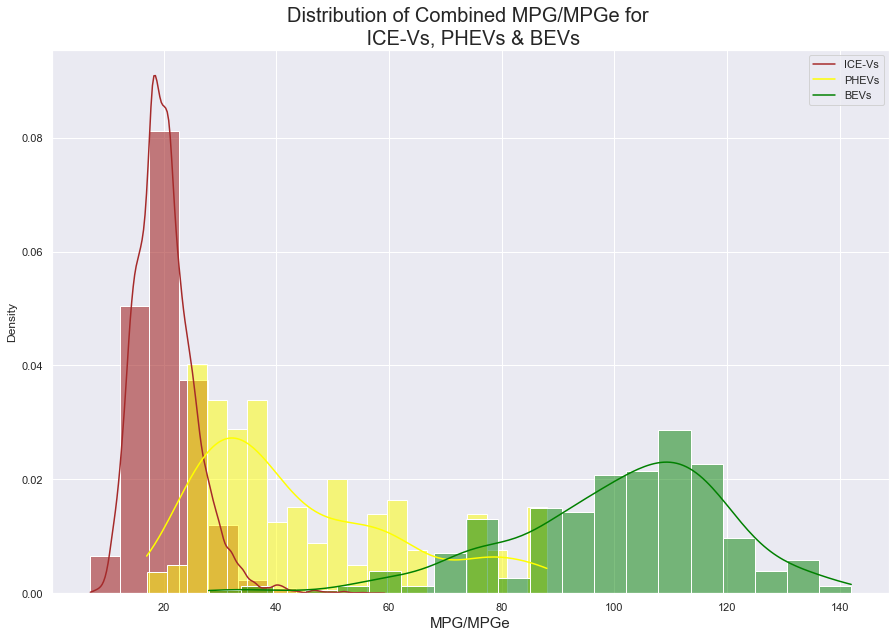

In [746]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('Distribution of Combined MPG/MPGe for \n ICE-Vs, PHEVs & BEVs', size = 20)
sns.histplot(x = df[df.ICE == 1].y, bins = 10, kde = True, label = 'ICE-Vs', stat='density', color = 'brown', alpha = .6)
sns.histplot(x = df[df.PHEV == 1].y, bins = 20, kde = True, label = 'PHEVs', stat='density', color = 'yellow')
sns.histplot(x = df[df.BEV == 1].y, bins = 20, kde = True, label = 'BEVs', stat='density', color = 'green', alpha = .5)

ax.legend(labels=['ICE-Vs', 'PHEVs', 'BEVs']);
ax.set_xlabel('MPG/MPGe', size=15)
plt.savefig('images/y_dist.png')#, transparent=True)
# plt.ylim([0,0.09])
;

In [747]:
df[df.BEV == 1].year.median()

2018.0

In [748]:
df[df.PHEV == 1].year.median()

2019.0

In [749]:
df[df.ICE == 1].year.median()

2004.0

In [760]:
np.std(df[df.ICE == 1].y)

5.295629767783694

In [759]:
np.std(df[df.PHEV == 1].y)

18.3256726322247

In [761]:
np.std(df[df.BEV == 1].y)

19.22181402549528

In [762]:
df[df.PHEV == 1].year.min()

2011

In [756]:
df[(df.ICE == 1) & (df.year == 2018)].value_counts().sum() # 1290 ICE vehicles from 2018
df[(df.ICE == 1) & (df.year == 2018)].y.median()

22.64425

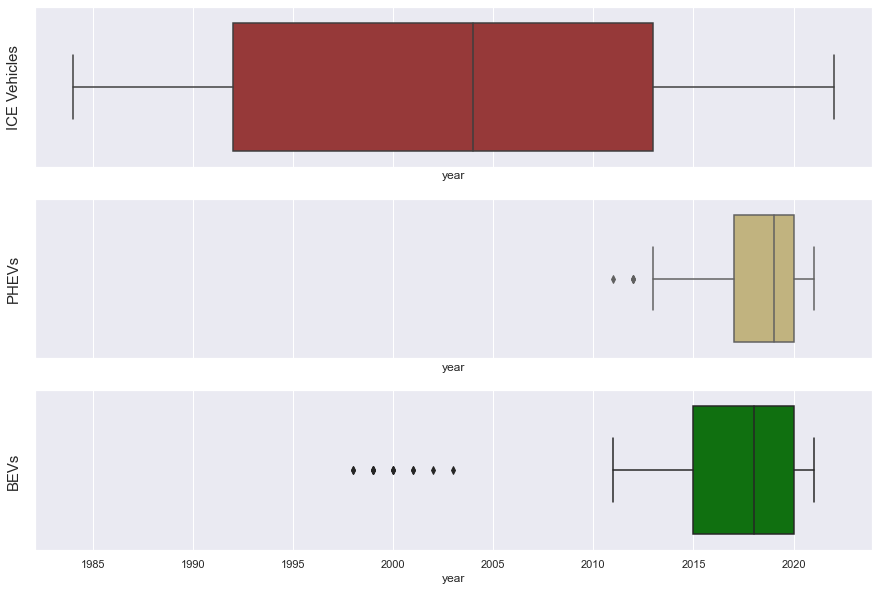

In [791]:
fig, ax = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
sns.boxplot(x=df[df.ICE == 1].year, color = 'brown', ax=ax[0])
sns.boxplot(x=df[df.PHEV == 1].year, color = 'y', ax=ax[1])
sns.boxplot(x=df[df.BEV == 1].year, color = 'green', ax=ax[2])
ax[0].set_ylabel('ICE Vehicles', size=15)
ax[1].set_ylabel('PHEVs', size=15)
ax[2].set_ylabel('BEVs', size=15)
plt.savefig('images/year_distA.png', transparent=True)
plt.show()

In [751]:
df[((df.ICE == 1) & (df.year == 2018)) | ((df.ICE == 1) & (df.year == 2019))].value_counts().sum()

2561

In [449]:
print(f'Total Vehicles represented in dataset: {len(df)}'), \
print(f'Total Vehicles with non-zero, non-null values for target: {len(df[df.y > 0])}')

Total Vehicles represented in dataset: 43495
Total Vehicles with non-zero, non-null values for target: 43495


(None, None)

#### `ICE` — Internal Combustion Engine Vehicles

- Target `y` for `ICE` vehicles will be created from `comb08U`, and `comb08` when `comb08U` is blank, for vehicles where `ICE` = 1.

In [402]:
print(f'Total ICE Vehicles: {len(df[(df.ICE == 1)])}'), \
print(f'Total Unrounded MPG ICE Vs: {len(df[(df.ICE == 1) & (df.comb08U == 0)])}'), \
print(f'Total ICE Vs w/ 0 for 08 AND 08U: {len(df[(df.ICE == 1) & (df.comb08U == 0) & (df.comb08 == 0)])}')

Total ICE Vehicles: 42991
Total Unrounded MPG ICE Vs: 29627
Total ICE Vs w/ 0 for 08 AND 08U: 0


(None, None, None)

In [405]:
len(df[df.y != 0])

42991

In [420]:
df[df.y > 500]

,year,make,model,comb08,comb08U,combA08,combA08U,combE,phevComb,combinedCD,combinedUF,cylinders,displ,drive,eng_dscr,evMotor,trany,trans_dscr,fuelType1,fuelType2,pv2,lv2,pv4,lv4,hpv,hlv,VClass,phevBlended,guzzler,tCharger,sCharger,atvType,startStop,co2,co2A,co2TailpipeAGpm,co2TailpipeGpm,BEV,PHEV,ICE,y


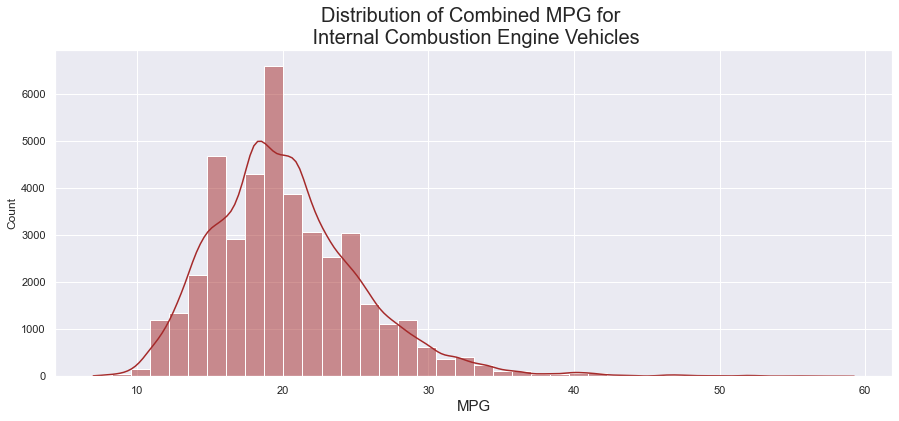

''

In [708]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Distribution of Combined MPG for \n Internal Combustion Engine Vehicles', size = 20)
sns.histplot(x = df[df.ICE == 1].y, bins = 40, kde = True, color = 'brown')
ax.set_xlabel('MPG', size=15)
plt.show()
;

#### `PHEV` — Plug-in Hybrid Electric Vehicles

- Target `y` will be created for PHEVs using the values for `phevComb`, with PHEVs identified using the engineered feature `PHEV`.

In [412]:
print(f'Total PHEV Vehicles: {len(df[df.PHEV == 1])}'), \
print(f'Total vehicles w/ non-zero phevComb value: {len(df[df.phevComb != 0])}'), \
print(f'Total vehicles that are in both above categories: {len(df[(df.PHEV == 1) & (df.phevComb != 0)])}')

Total PHEV Vehicles: 224
Total vehicles w/ non-zero phevComb value: 224
Total vehicles that are in both above categories: 224


(None, None, None)

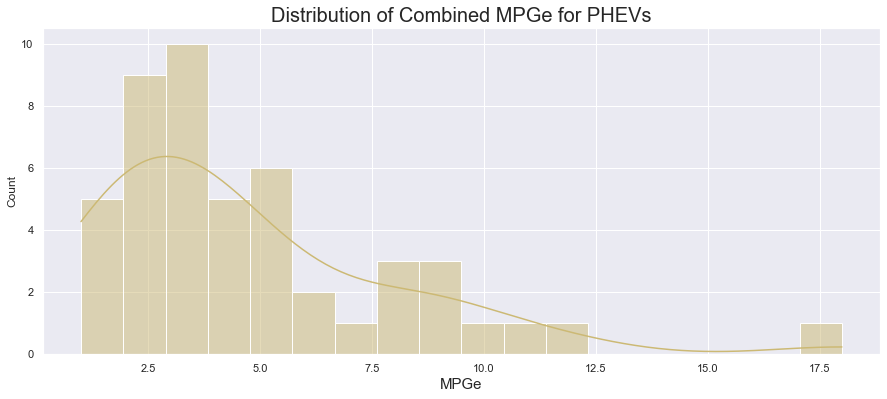

''

In [439]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Distribution of Combined MPGe for PHEVs', size = 20)
sns.histplot(x = df[df.PHEV == 1].y.value_counts(), bins = 18, kde = True, color = 'y')
ax.set_xlabel('MPGe', size=15)
# plt.savefig('images/phev_distA.png', transparent=True)
plt.show()
;

#### `BEV` — *pure* Battery Electric Vehicles

- Target `y` will be created from `comb08` for vehicles where `BEV` = 1.
- This one is a bit more confusing to compare to the other two, as there is no gas fuel, MPG sounds a bit cryptic. Fortunately the kwH/100 is listed in `combE`, which appears to coordinate well with the MPGe figure listed under `comb08`.
  
  Additional info from [Edmund's](https://www.edmunds.com/fuel-economy/decoding-electric-car-mpg.html)  
  Additional info from [Fisher Honda](https://www.fisherhonda.com/how-to-calculate-mpge-vs-mpg/):
  > A vehicle’s MPG rating is fairly self explanatory. It’s the number of miles your car can drive per gallon of gas. Figuring out an MPGe rating is a little more complicated. Since engines that use an alternative source of fuel can’t be measured by liquid gallons of fuel, the MPGe rating is calculated by figuring out the number of miles a vehicle can go using the same energy content as a gallon of gas. The EPA calculates that 33.7 kilowatt-hours of electricity is the equivalent to one gallon of gas, so an electric or hybrid vehicle that uses 29 kWh per 100 miles would get a combined 115 MPGe rating.  

In [435]:
print(f'Total BEV Vehicles: {len(df[df.BEV == 1])}')

Total BEV Vehicles: 280


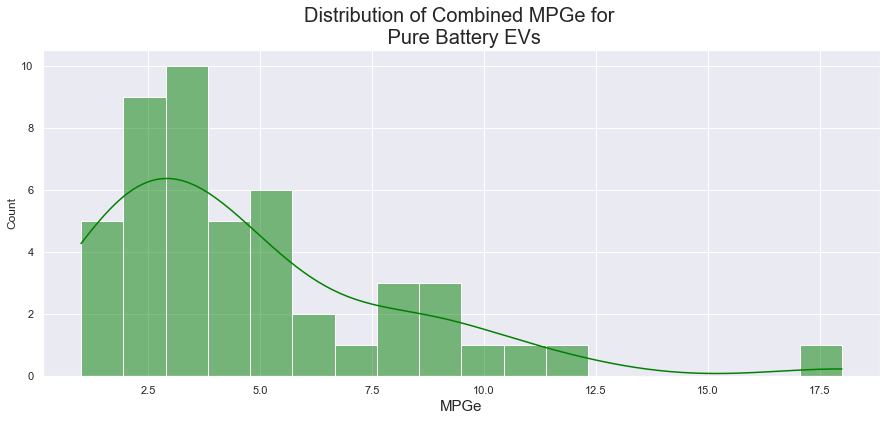

''

In [443]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Distribution of Combined MPGe for \n Pure Battery EVs', size = 20)
sns.histplot(x = df[df.PHEV == 1].y.value_counts(), bins = 18, kde = True, color = 'green')
ax.set_xlabel('MPGe', size=15)
# plt.savefig('images/bev_dist.png')
plt.show()
;

In [429]:
df[df.BEV == 1]

,year,make,model,comb08,comb08U,combA08,combA08U,combE,phevComb,combinedCD,combinedUF,cylinders,displ,drive,eng_dscr,evMotor,trany,trans_dscr,fuelType1,fuelType2,pv2,lv2,pv4,lv4,hpv,hlv,VClass,phevBlended,guzzler,tCharger,sCharger,atvType,startStop,co2,co2A,co2TailpipeAGpm,co2TailpipeGpm,BEV,PHEV,ICE,y
7138,2000,Nissan,Altra EV,85,0.0000,0,0.0,40.0000,0,0.0,0.0,0.0,0.0,NaN,NaN,62 KW AC Induction,NaN,NaN,Electricity,NaN,0,0,0,0,0,0,Station Wagons,0,0,NaN,NaN,EV,0,0,-1,0.0,0.0,1,0,0,0.0
7139,2000,Toyota,RAV4 EV,72,0.0000,0,0.0,47.0000,0,0.0,0.0,0.0,0.0,RWD,NaN,50 KW DC,NaN,NaN,Electricity,NaN,0,0,0,0,0,0,SUV,0,0,NaN,NaN,EV,0,0,-1,0.0,0.0,1,0,0,0.0
8143,2001,Toyota,RAV4 EV,72,0.0000,0,0.0,47.0000,0,0.0,0.0,0.0,0.0,RWD,NaN,50 KW DC,NaN,NaN,Electricity,NaN,0,0,0,0,0,0,SUV,0,0,NaN,NaN,EV,0,0,-1,0.0,0.0,1,0,0,0.0
8144,2001,Ford,Th!nk,65,0.0000,0,0.0,52.0000,0,0.0,0.0,0.0,0.0,NaN,NaN,27 KW AC Induction,NaN,NaN,Electricity,NaN,0,0,0,0,0,0,Two Seaters,0,0,NaN,NaN,EV,0,0,-1,0.0,0.0,1,0,0,0.0
8146,2001,Ford,Explorer USPS Electric,39,0.0000,0,0.0,87.0000,0,0.0,0.0,0.0,0.0,RWD,NaN,67 KW AC Induction,NaN,NaN,Electricity,NaN,0,0,0,0,0,0,SUV,0,0,NaN,NaN,EV,0,0,-1,0.0,0.0,1,0,0,0.0
8147,2001,Nissan,Hyper-Mini,75,0.0000,0,0.0,45.0000,0,0.0,0.0,0.0,0.0,NaN,NaN,24 KW AC Synchronous,NaN,NaN,Electricity,NaN,0,0,0,0,0,0,Two Seaters,0,0,NaN,NaN,EV,0,0,-1,0.0,0.0,1,0,0,0.0
9212,2002,Toyota,RAV4 EV,78,0.0000,0,0.0,43.0000,0,0.0,0.0,0.0,0.0,RWD,NaN,50 KW DC,NaN,NaN,Electricity,NaN,0,0,0,0,0,0,SUV,0,0,NaN,NaN,EV,0,0,-1,0.0,0.0,1,0,0,0.0
9213,2002,Ford,Explorer USPS Electric,39,0.0000,0,0.0,87.0000,0,0.0,0.0,0.0,0.0,RWD,NaN,67 KW AC Induction,NaN,NaN,Electricity,NaN,0,0,0,0,0,0,SUV,0,0,NaN,NaN,EV,0,0,-1,0.0,0.0,1,0,0,0.0
10329,2003,Toyota,RAV4 EV,78,0.0000,0,0.0,43.0000,0,0.0,0.0,0.0,0.0,RWD,NaN,50 KW DC,NaN,NaN,Electricity,NaN,0,0,0,0,0,0,SUV,0,0,NaN,NaN,EV,0,0,-1,0.0,0.0,1,0,0,0.0
23016,2001,Ford,Ranger Pickup 2WD,58,0.0000,0,0.0,58.0000,0,0.0,0.0,0.0,0.0,RWD,NaN,67 KW AC Induction,Automatic (A1),NaN,Electricity,NaN,0,0,0,0,0,0,Pickup Trucks,0,0,NaN,NaN,EV,0,0,-1,0.0,0.0,1,0,0,0.0


In [412]:
print(f'Total BEV Vehicles: {len(df[df.BEV == 1])}'), \
print(f'Total vehicles w/ non-zero phevComb value: {len(df[df.phevComb != 0])}'), \
print(f'Total vehicles that are in both above categories: {len(df[(df.PHEV == 1) & (df.phevComb != 0)])}')

Total PHEV Vehicles: 224
Total vehicles w/ non-zero phevComb value: 224
Total vehicles that are in both above categories: 224


(None, None, None)

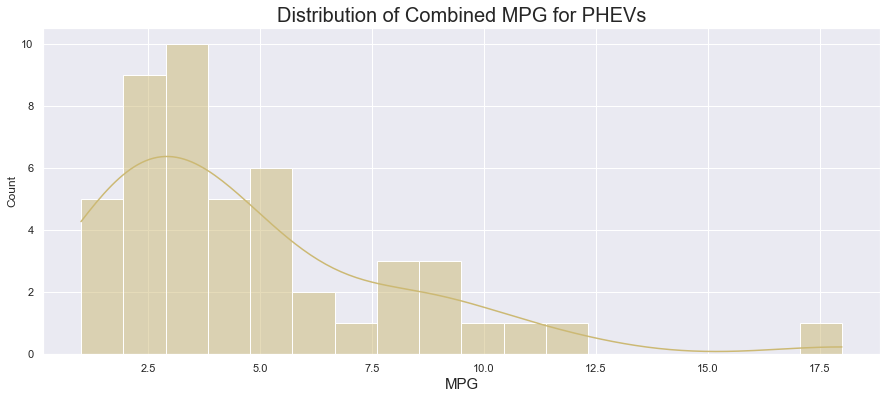

''

In [428]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Distribution of Combined MPG for PHEVs', size = 20)
sns.histplot(x = df[df.PHEV == 1].y.value_counts(), bins = 18, kde = True, color = 'y')
ax.set_xlabel('MPG', size=15)
# plt.savefig('images/phev_distA.png', transparent=True)
plt.show()
;

### `year`

- Year of vehicle model

### `cylinders`

- 283 null values in this column
  - 280 of them are electric vehicles. The values for these have been set to 0.
  - 2 are Suburu RX Turbos from the same year. Imputed value to 4 (though these will probably get dropped due to having NaN values for `eng_dscr`
  - 1 is a Mazda RX that is a duplicate entry and will be **dropped**

In [41]:
df.cylinders.value_counts()

4.0     16950
6.0     14945
8.0      9270
5.0       774
12.0      675
3.0       343
10.0      179
2.0        63
16.0       14
Name: cylinders, dtype: int64

In [136]:
len(df[df.fuelType == 'Electricity'].cylinders)

280

In [140]:
df[(df.fuelType != 'Electricity') & (df.cylinders.isna())]

,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,cityUF,co2,co2A,co2TailpipeAGpm,co2TailpipeGpm,comb08,comb08U,combA08,combA08U,combE,combinedCD,combinedUF,cylinders,displ,drive,engId,eng_dscr,feScore,fuelCost08,fuelCostA08,fuelType,fuelType1,ghgScore,ghgScoreA,highway08,highway08U,highwayA08,highwayA08U,highwayCD,highwayE,highwayUF,hlv,hpv,id,lv2,lv4,make,model,mpgData,phevBlended,pv2,pv4,range,rangeCity,rangeCityA,rangeHwy,rangeHwyA,trany,UCity,UCityA,UHighway,UHighwayA,VClass,year,youSaveSpend,guzzler,trans_dscr,tCharger,sCharger,atvType,fuelType2,rangeA,evMotor,mfrCode,c240Dscr,charge240b,c240bDscr,createdOn,modifiedOn,startStop,phevCity,phevHwy,phevComb
21410,13.733750,0.0,0.0,0.0,22,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,370.291667,24,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,4-Wheel Drive,0,NaN,-1,1800,0,Regular,Regular Gasoline,-1,-1,28,0.0,0,0.0,0.0,0.0,0.0,0,0,29472,0,0,Subaru,RX Turbo,N,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,27.4000,0.0,38.8000,0.0,Subcompact Cars,1985,-1000,0,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
21411,14.330870,0.0,0.0,0.0,21,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,386.391304,23,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,4-Wheel Drive,0,CA model,-1,1850,0,Regular,Regular Gasoline,-1,-1,27,0.0,0,0.0,0.0,0.0,0.0,0,0,29473,0,0,Subaru,RX Turbo,N,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,26.9000,0.0,37.1000,0.0,Subcompact Cars,1985,-1250,0,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
21500,18.311667,0.0,0.0,0.0,15,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,493.722222,18,0.0,0,0.0,0.0,0.0,0.0,NaN,1.3,Rear-Wheel Drive,0,NaN,-1,2400,0,Regular,Regular Gasoline,-1,-1,22,0.0,0,0.0,0.0,0.0,0.0,0,0,29557,0,0,Mazda,RX-7,N,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,19.0473,0.0,31.1094,0.0,Two Seaters,1986,-4000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0


In [149]:
df[(df.make == 'Subaru') & (df.year < 1994)]

,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,cityUF,co2,co2A,co2TailpipeAGpm,co2TailpipeGpm,comb08,comb08U,combA08,combA08U,combE,combinedCD,combinedUF,cylinders,displ,drive,engId,eng_dscr,feScore,fuelCost08,fuelCostA08,fuelType,fuelType1,ghgScore,ghgScoreA,highway08,highway08U,highwayA08,highwayA08U,highwayCD,highwayE,highwayUF,hlv,hpv,id,lv2,lv4,make,model,mpgData,phevBlended,pv2,pv4,range,rangeCity,rangeCityA,rangeHwy,rangeHwyA,trany,UCity,UCityA,UHighway,UHighwayA,VClass,year,youSaveSpend,guzzler,trans_dscr,tCharger,sCharger,atvType,fuelType2,rangeA,evMotor,mfrCode,c240Dscr,charge240b,c240bDscr,createdOn,modifiedOn,startStop,phevCity,phevHwy,phevComb
4,17.347895,0.0,0.0,0.0,17,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,467.736842,19,0.0,0,0.0,0.0,0.0,0.0,4.0,2.2,4-Wheel or All-Wheel Drive,66031,"(FFS,TRBO)",-1,2750,0,Premium,Premium Gasoline,-1,-1,23,0.0,0,0.0,0.0,0.0,0.0,0,0,10000,0,14,Subaru,Legacy AWD Turbo,N,False,0,90,0,0.0,0.0,0.0,0.0,Manual 5-spd,21.0000,0.0,32.0000,0.0,Compact Cars,1993,-5750,0,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
5,14.982273,0.0,0.0,0.0,21,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,403.954545,22,0.0,0,0.0,0.0,0.0,0.0,4.0,1.8,Front-Wheel Drive,66020,(FFS),-1,1950,0,Regular,Regular Gasoline,-1,-1,24,0.0,0,0.0,0.0,0.0,0.0,0,0,10001,0,15,Subaru,Loyale,N,False,0,88,0,0.0,0.0,0.0,0.0,Automatic 3-spd,27.0000,0.0,33.0000,0.0,Compact Cars,1993,-1750,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
6,13.184400,0.0,0.0,0.0,22,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,355.480000,25,0.0,0,0.0,0.0,0.0,0.0,4.0,1.8,Front-Wheel Drive,66020,(FFS),-1,1700,0,Regular,Regular Gasoline,-1,-1,29,0.0,0,0.0,0.0,0.0,0.0,0,0,10002,0,15,Subaru,Loyale,Y,False,0,88,0,0.0,0.0,0.0,0.0,Manual 5-spd,28.0000,0.0,41.0000,0.0,Compact Cars,1993,-500,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
173,14.982273,0.0,0.0,0.0,19,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,403.954545,22,0.0,0,0.0,0.0,0.0,0.0,4.0,2.2,Front-Wheel Drive,66030,(FFS),-1,1950,0,Regular,Regular Gasoline,-1,-1,26,0.0,0,0.0,0.0,0.0,0.0,0,0,10153,0,36,Subaru,Legacy Wagon,Y,False,0,92,0,0.0,0.0,0.0,0.0,Automatic 4-spd,24.0000,0.0,37.0000,0.0,Small Station Wagons,1993,-1750,0,CLKUP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
174,14.330870,0.0,0.0,0.0,20,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,386.391304,23,0.0,0,0.0,0.0,0.0,0.0,4.0,2.2,Front-Wheel Drive,66030,(FFS),-1,1850,0,Regular,Regular Gasoline,-1,-1,28,0.0,0,0.0,0.0,0.0,0.0,0,0,10154,0,36,Subaru,Legacy Wagon,N,False,0,92,0,0.0,0.0,0.0,0.0,Manual 5-spd,25.0000,0.0,39.0000,0.0,Small Station Wagons,1993,-1250,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
175,15.695714,0.0,0.0,0.0,18,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,423.190476,21,0.0,0,0.0,0.0,0.0,0.0,4.0,2.2,4-Wheel or All-Wheel Drive,66030,(FFS),-1,2050,0,Regular,Regular Gasoline,-1,-1,24,0.0,0,0.0,0.0,0.0,0.0,0,0,10155,0,36,Subaru,Legacy Wagon AWD,Y,False,0,92,0,0.0,0.0,0.0,0.0,Automatic 4-spd,23.0000,0.0,34.0000,0.0,Small Station Wagons,1993,-2250,0,CLKUP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
176,15.695714,0.0,0.0,0.0,18,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,423.190476,21,0.0,0,0.0,0.0,0.0,0.0,4.0,2.2,4-Wheel or All-Wheel Drive,66030,(FFS),-1,2050,0,Regular,Regular Gasoline,-1,-1,24,0.0,0,0.0,0.0,0.0,0.0,0,0,10156,0,36,Subaru,Legacy Wagon AWD,Y,False,0,92,0,0.0,0.0,0.0,0.0,Manual 5-spd,23.0000,0.0,34.0000,0.0,Small Station Wagons,1993,-2250,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
177,18.311667,0.0,0.0,0.0,16,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,493.722222,18,0.0,0,0.0,0.0,0.0,0.0,4.0,2.2,4-Wheel or All-Wheel Drive

In [148]:
df[(df.make == 'Subaru') & (df.model == 'RX Turbo')] # impute cylinders to 4

,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,cityUF,co2,co2A,co2TailpipeAGpm,co2TailpipeGpm,comb08,comb08U,combA08,combA08U,combE,combinedCD,combinedUF,cylinders,displ,drive,engId,eng_dscr,feScore,fuelCost08,fuelCostA08,fuelType,fuelType1,ghgScore,ghgScoreA,highway08,highway08U,highwayA08,highwayA08U,highwayCD,highwayE,highwayUF,hlv,hpv,id,lv2,lv4,make,model,mpgData,phevBlended,pv2,pv4,range,rangeCity,rangeCityA,rangeHwy,rangeHwyA,trany,UCity,UCityA,UHighway,UHighwayA,VClass,year,youSaveSpend,guzzler,trans_dscr,tCharger,sCharger,atvType,fuelType2,rangeA,evMotor,mfrCode,c240Dscr,charge240b,c240bDscr,createdOn,modifiedOn,startStop,phevCity,phevHwy,phevComb
21410,13.73375,0.0,0.0,0.0,22,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,370.291667,24,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,4-Wheel Drive,0,NaN,-1,1800,0,Regular,Regular Gasoline,-1,-1,28,0.0,0,0.0,0.0,0.0,0.0,0,0,29472,0,0,Subaru,RX Turbo,N,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,27.4,0.0,38.8,0.0,Subcompact Cars,1985,-1000,0,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
21411,14.33087,0.0,0.0,0.0,21,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,386.391304,23,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,4-Wheel Drive,0,CA model,-1,1850,0,Regular,Regular Gasoline,-1,-1,27,0.0,0,0.0,0.0,0.0,0.0,0,0,29473,0,0,Subaru,RX Turbo,N,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,26.9,0.0,37.1,0.0,Subcompact Cars,1985,-1250,0,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0


In [146]:
df[(df.make == 'Mazda') & (df.model == 'RX-7') & (df.year == 1986)] # drop the lower, appears to be a duplicate

,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,cityUF,co2,co2A,co2TailpipeAGpm,co2TailpipeGpm,comb08,comb08U,combA08,combA08U,combE,combinedCD,combinedUF,cylinders,displ,drive,engId,eng_dscr,feScore,fuelCost08,fuelCostA08,fuelType,fuelType1,ghgScore,ghgScoreA,highway08,highway08U,highwayA08,highwayA08U,highwayCD,highwayE,highwayUF,hlv,hpv,id,lv2,lv4,make,model,mpgData,phevBlended,pv2,pv4,range,rangeCity,rangeCityA,rangeHwy,rangeHwyA,trany,UCity,UCityA,UHighway,UHighwayA,VClass,year,youSaveSpend,guzzler,trans_dscr,tCharger,sCharger,atvType,fuelType2,rangeA,evMotor,mfrCode,c240Dscr,charge240b,c240bDscr,createdOn,modifiedOn,startStop,phevCity,phevHwy,phevComb
8145,18.311667,0.0,0.0,0.0,15,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,493.722222,18,0.0,0,0.0,0.0,0.0,0.0,2.0,1.3,Rear-Wheel Drive,56010,(FFS),-1,2400,0,Regular,Regular Gasoline,-1,-1,22,0.0,0,0.0,0.0,0.0,0.0,0,0,1733,10,0,Mazda,RX-7,Y,False,69,0,0,0.0,0.0,0.0,0.0,Automatic 4-spd,19.0000,0.0,30.7692,0.0,Minicompact Cars,1986,-4000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
21500,18.311667,0.0,0.0,0.0,15,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,493.722222,18,0.0,0,0.0,0.0,0.0,0.0,NaN,1.3,Rear-Wheel Drive,0,NaN,-1,2400,0,Regular,Regular Gasoline,-1,-1,22,0.0,0,0.0,0.0,0.0,0.0,0,0,29557,0,0,Mazda,RX-7,N,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,19.0473,0.0,31.1094,0.0,Two Seaters,1986,-4000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0


In [154]:
df[(df.make == 'Subaru') & (df.model == 'RX Turbo')]

,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,cityUF,co2,co2A,co2TailpipeAGpm,co2TailpipeGpm,comb08,comb08U,combA08,combA08U,combE,combinedCD,combinedUF,cylinders,displ,drive,engId,eng_dscr,feScore,fuelCost08,fuelCostA08,fuelType,fuelType1,ghgScore,ghgScoreA,highway08,highway08U,highwayA08,highwayA08U,highwayCD,highwayE,highwayUF,hlv,hpv,id,lv2,lv4,make,model,mpgData,phevBlended,pv2,pv4,range,rangeCity,rangeCityA,rangeHwy,rangeHwyA,trany,UCity,UCityA,UHighway,UHighwayA,VClass,year,youSaveSpend,guzzler,trans_dscr,tCharger,sCharger,atvType,fuelType2,rangeA,evMotor,mfrCode,c240Dscr,charge240b,c240bDscr,createdOn,modifiedOn,startStop,phevCity,phevHwy,phevComb
21410,13.73375,0.0,0.0,0.0,22,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,370.291667,24,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,4-Wheel Drive,0,NaN,-1,1800,0,Regular,Regular Gasoline,-1,-1,28,0.0,0,0.0,0.0,0.0,0.0,0,0,29472,0,0,Subaru,RX Turbo,N,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,27.4,0.0,38.8,0.0,Subcompact Cars,1985,-1000,0,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
21411,14.33087,0.0,0.0,0.0,21,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,386.391304,23,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,4-Wheel Drive,0,CA model,-1,1850,0,Regular,Regular Gasoline,-1,-1,27,0.0,0,0.0,0.0,0.0,0.0,0,0,29473,0,0,Subaru,RX Turbo,N,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,26.9,0.0,37.1,0.0,Subcompact Cars,1985,-1250,0,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0


In [138]:
df.cylinders.isna().sum()

283

In [128]:
df[df.cylinders.isna()][['fuelType', 'fuelType1', 'fuelType2', 'make', 'model', 'year', 'eng_dscr']]

,fuelType,fuelType1,fuelType2,make,model,year,eng_dscr
7138,Electricity,Electricity,NaN,Nissan,Altra EV,2000,NaN
7139,Electricity,Electricity,NaN,Toyota,RAV4 EV,2000,NaN
8143,Electricity,Electricity,NaN,Toyota,RAV4 EV,2001,NaN
8144,Electricity,Electricity,NaN,Ford,Th!nk,2001,NaN
8146,Electricity,Electricity,NaN,Ford,Explorer USPS Electric,2001,NaN
8147,Electricity,Electricity,NaN,Nissan,Hyper-Mini,2001,NaN
9212,Electricity,Electricity,NaN,Toyota,RAV4 EV,2002,NaN
9213,Electricity,Electricity,NaN,Ford,Explorer USPS Electric,2002,NaN
10329,Electricity,Electricity,NaN,Toyota,RAV4 EV,2003,NaN
21410,Regular,Regular Gasoline,NaN,Subaru,RX Turbo,1985,NaN


### `trany` — $#OHE#$

- Represents class of transmission. 
- Categorical feature with classes that will be **one hot encoded**.
- Fortunately, the values are fairly consistent and won't require much cleaning.

In [304]:
df.trany.value_counts()

Automatic 4-spd                     11048
Manual 5-spd                         8375
Automatic (S6)                       3256
Automatic 3-spd                      3151
Manual 6-spd                         2900
Automatic (S8)                       2246
Automatic 5-spd                      2203
Automatic 6-spd                      1726
Manual 4-spd                         1483
Automatic (variable gear ratios)      935
Automatic (S5)                        839
Automatic 7-spd                       719
Automatic 8-spd                       629
Automatic (AM-S7)                     564
Automatic 9-spd                       506
Automatic (S7)                        354
Automatic (AM7)                       287
Automatic (A1)                        281
Automatic (S10)                       258
Automatic (AV-S6)                     247
Automatic (S4)                        233
Automatic (AV-S7)                     174
Automatic (AM6)                       160
Automatic (S9)                    

### `displ`

- **displ** - engine displacement in liters
- cleaned by setting displacement values for EVs to zero.

In [272]:
df[df.displ == 0]

,year,make,model,comb08,comb08U,combA08,combA08U,combE,phevComb,combinedCD,combinedUF,cylinders,displ,drive,eng_dscr,evMotor,trany,trans_dscr,fuelType1,fuelType2,pv2,lv2,pv4,lv4,hpv,hlv,VClass,phevBlended,guzzler,tCharger,sCharger,atvType,startStop,co2,co2A,co2TailpipeAGpm,co2TailpipeGpm
28578,2016,Mitsubishi,i-MiEV,112,112.2077,0,0.0,30.0,0,0.0,0.0,0.0,0.0,Rear-Wheel Drive,NaN,49 kW DCPM,Automatic (A1),NaN,Electricity,NaN,0,0,0,0,85,13,Subcompact Cars,0,0,NaN,NaN,EV,0,0,-1,0.0,0.0


In [335]:
len(df[df.displ == 0])

282

In [276]:
# previously when exploring the cylinders feature I had seen that there were 
# roughly 280 BEVs in the dataset, which the figure below approximates.
# Clean by setting null values to 0
df.displ.isna().sum() 

281

In [352]:
len(df[df.BEV == 1]) #280

280

In [343]:
df[(df.displ == 0) & (df.fuelType1 != 'Electricity')]

,year,make,model,comb08,comb08U,combA08,combA08U,combE,phevComb,combinedCD,combinedUF,cylinders,displ,drive,eng_dscr,evMotor,trany,trans_dscr,fuelType1,fuelType2,pv2,lv2,pv4,lv4,hpv,hlv,VClass,phevBlended,guzzler,tCharger,sCharger,atvType,startStop,co2,co2A,co2TailpipeAGpm,co2TailpipeGpm
21410,1985,Subaru,RX Turbo,24,0.0,0,0.0,0.0,0,0.0,0.0,4.0,0.0,4WD,NaN,NaN,Manual 5-spd,NaN,Regular Gasoline,NaN,0,0,0,0,0,0,Subcompact Cars,0,0,T,NaN,NaN,0,-1,-1,0.0,370.291667
21411,1985,Subaru,RX Turbo,23,0.0,0,0.0,0.0,0,0.0,0.0,4.0,0.0,4WD,CA model,NaN,Manual 5-spd,NaN,Regular Gasoline,NaN,0,0,0,0,0,0,Subcompact Cars,0,0,T,NaN,NaN,0,-1,-1,0.0,386.391304


In [348]:
df.displ.value_counts()

2.0    4869
3.0    3663
2.5    2711
2.4    2068
3.5    1863
1.8    1671
1.6    1669
5.0    1596
4.3    1401
2.2    1385
4.0    1253
3.6    1186
2.3    1181
5.7    1153
3.8    1044
2.8    1012
5.3     967
1.5     940
6.2     753
3.7     605
5.2     585
4.6     578
2.7     574
3.2     547
4.2     538
3.3     508
6.0     454
3.4     439
1.9     418
4.4     394
4.7     384
4.9     352
2.6     340
3.9     338
5.9     338
1.4     318
5.4     308
0.0     282
4.8     267
3.1     255
2.9     252
5.5     219
5.6     215
1.3     209
1.0     174
5.8     160
6.8     143
6.5     134
2.1     100
4.1      95
4.5      90
6.7      84
1.7      76
6.4      67
1.2      62
6.3      46
6.6      45
8.0      29
6.1      24
1.1      12
0.6      12
8.4      11
7.0      10
8.3       9
0.9       6
7.4       4
Name: displ, dtype: int64

In [273]:
df.displ.value_counts().sum()

43214

In [ ]:
df[(df.make == 'Subaru') & (df.cylinders == 4)].displ.median()

### `drive`

- **drive** - drive axle type
- multiclass categorical feature that will be one hot encoded.
- clean by combining `'4-Wheel or All-Wheel Drive'`, `'All-Wheel Drive'` and `'4-Wheel Drive'`.
- clean by managing `'2-Wheel Drive'` in to either `'Rear-Wheel Drive'` or `'Front-Wheel Drive'`.
- clean by simplifying class name `'Part-time 4-Wheel Drive'` in to `'pt4WD'`.
  - I labored a little over this decision. Should I classify them as 2WD, which these vehicles would be most of the time on the road (other vehicles already classified as 4WD seem to more often be authenitcally full-time 4WD), or 4WD, since they have 4WD capability? Ultimately I set them as their own distinct class, despite representing less than 1% of all vehicles.

In [301]:
df[df.drive == '4WD'].make.value_counts()

Chevrolet                        1128
GMC                              1071
Audi                              815
Ford                              793
Subaru                            729
BMW                               696
Jeep                              648
Porsche                           580
Mercedes-Benz                     577
Toyota                            522
Dodge                             518
Nissan                            330
Mitsubishi                        296
Volvo                             263
Land Rover                        247
Lexus                             213
Suzuki                            187
Mazda                             184
Cadillac                          179
Infiniti                          170
Isuzu                             159
Volkswagen                        152
Honda                             145
Kia                               131
Jaguar                            129
Lincoln                           129
Lamborghini 

In [299]:
df[df.drive == 'Part-time 4-Wheel Drive'].model.value_counts()

Tacoma 4WD                                         43
F150 Pickup 4WD                                    31
F150 Pickup 4WD FFV                                26
Tundra 4WD                                         22
Sequoia 4WD                                        15
4Runner 4WD                                        12
Tundra 4WD FFV                                     10
F150 4WD BASE PAYLOAD LT TIRE                      10
Frontier 4WD                                       10
FF                                                 10
Sequoia 4WD FFV                                     9
Navigator 4WD                                       7
Expedition 4WD                                      7
FJ Cruiser 4WD                                      5
Titan 4WD                                           5
Explorer AWD                                        5
F150 RAPTOR 4WD                                     4
F150 Raptor Pickup 4WD                              4
GTC4Lusso                   

In [303]:
df.drive.value_counts()

RWD      14932
FWD      14799
4WD      12259
pt4WD      319
Name: drive, dtype: int64

In [286]:
df[df.drive == '2-Wheel Drive'].model.value_counts()

Truck 2WD                        30
Ranger Pickup 2WD                22
F150 Pickup 2WD                  20
C15 Pickup 2WD                   19
C10 Pickup 2WD                   19
Pickup 2WD                       19
S15 Pickup 2WD                   18
S10 Pickup 2WD                   18
Ram 50 Pickup 2WD                17
Vandura G15/25 2WD               16
G10/20 Van 2WD                   16
E150 Econoline 2WD               15
D100/D150 Pickup 2WD             14
F250 Pickup 2WD                  13
E150 Club Wagon 2WD              12
S10 Blazer 2WD                   11
G10/20 Sport Van 2WD             11
E250 Econoline 2WD               11
S15 Jimmy 2WD                    11
G15/25 Rally 2WD                 11
B150/B250 Van 2WD                10
C20 Pickup 2WD                   10
C25 Pickup 2WD                   10
B150/B250 Wagon 2WD               9
Caballero Pickup 2WD              9
El Camino Pickup 2WD              9
D250 Pickup 2WD                   8
B2000/B2200 Pickup 2WD      

###  `fuelType1`

- **fuelType1** - fuel type 1. For single fuel vehicles, this will be the only fuel. For dual fuel vehicles, this **will** be the conventional fuel.
  
Attributes Formerly Included:  
- **fuelType** - fuel type with fuelType1 and fuelType2 (if applicable) **DROP**
- **fuelType2** - fuel type 2. For dual fuel vehicles, this will be the alternative fuel (e.g. E85, Electricity, CNG, LPG). For single fuel vehicles, this field is not used.
  - **DROP** after using for distinguishing ICE vehicles, PHEVs, and BEVs from each other.

- Drop either `fuelType1` and `fuelType2` and keep the non-numbered feature, or drop the latter two and keep `fuelType`. The latter two combined privide the same info as the first.  
- I'm mad curious what a propane-powered vehicle looks like.  
> Hint: it's Ford tough.

In [74]:
type(df.iloc[2:3].fuelType)

pandas.core.series.Series

In [60]:
df.fuelType.value_counts()

Regular                        27420
Premium                        12672
Gasoline or E85                 1352
Diesel                          1203
Electricity                      280
Midgrade                         130
Premium or E85                   127
Premium and Electricity          100
Regular Gas and Electricity       63
CNG                               60
Premium Gas or Electricity        57
Gasoline or natural gas           20
Gasoline or propane                8
Regular Gas or Electricity         4
Name: fuelType, dtype: int64

In [454]:
df[df.fuelType1 == 'Electricity'].fuelType2.value_counts()

Series([], Name: fuelType2, dtype: int64)

In [62]:
df.fuelType1.value_counts()

Regular Gasoline     28867
Premium Gasoline     12956
Diesel                1203
Electricity            280
Midgrade Gasoline      130
Natural Gas             60
Name: fuelType1, dtype: int64

In [63]:
df.fuelType2.value_counts()

E85            1479
Electricity     224
Natural Gas      20
Propane           8
Name: fuelType2, dtype: int64

In [353]:
df[df.fuelType2 == 'Electricity'].fuelType1.value_counts() # All PHEVs

Premium Gasoline    157
Regular Gasoline     67
Name: fuelType1, dtype: int64

### `phevBlended`

- **phevBlended** - if true, this vehicle operates on a blend of gasoline and electricity in charge depleting

- Binary class. Will set 'True' values to 1 and 'False' values to 0.

In [451]:
df.phevBlended.value_counts()

0    43332
1      163
Name: phevBlended, dtype: int64

### `startStop`

- **startStop** - vehicle has start-stop technology (Y, N, or blank for older vehicles)  
The NaN values are manageable. This should be a **binary** class.

In [181]:
df.startStop.value_counts()

N    7186
Y    4621
Name: startStop, dtype: int64

In [183]:
df.startStop.value_counts()

0    38874
1     4621
Name: startStop, dtype: int64

- **trans_dscr** - transmission descriptor; see http://www.fueleconomy.gov/feg/findacarhelp.shtml#trany

- Will **one hot encode** these classes. 
- I will do further research in to the difference and consolodate the transmissions with lower value counts in to the classes that they are most similar to.
- on second thought, $\frac{2}{3}$ of these are null. **DROP**

In [220]:
df.trans_dscr.isna().value_counts()

True     28451
False    15044
Name: trans_dscr, dtype: int64

In [217]:
df[df.trans_dscr == 'SIL'].trany.value_counts()

Manual 5-spd       1887
Manual 4-spd        277
Manual 6-spd         18
Automatic 4-spd       7
Name: trany, dtype: int64

In [213]:
df.trans_dscr.value_counts()

CLKUP              7809
SIL                2189
2MODE CLKUP        1235
Creeper             525
EMS 2MODE CLKUP     517
3MODE CLKUP         517
2MODE               448
2MODE 2LKUP         383
EMS                 252
3MODE               166
CMODE               150
CMODE CLKUP         130
VMODE CLKUP         105
SIL Creeper          72
2LKUP                63
DC/FW                53
VLKUP                52
EMS CLKUP            50
EMS 2MODE            46
6MODE CLKUP          41
4MODE                35
VMODE VLKUP          26
2MODE 3LKUP          22
2MODE DC/FW          19
CMODE VLKUP          17
3LKUP                15
EMS 3MODE            11
Overdrive            10
Lockup                9
2MODE VLKUP           9
SIL EMS               7
4MODE CLKUP           6
SIL 3MODE             6
6MODE                 6
EMS 2MODE CLKU        5
SIL 2MODE CLKUP       5
3MODE VLKUP           5
Mech Overdrive        3
Elec Overdrive        3
EMS 3MODE CLKUP       3
SIL CMODE             2
SIL 3MODE CLKUP 

### `VClass`

- **VClass** - EPA vehicle size class
- Will need to combine classes to remove drivetrain, as that is accounted for in its own feature and will cause multicolinearity if detailed in here as well.

In [333]:
df.VClass.value_counts()

SUV                         6879
Pickup Trucks               6196
Compact Cars                6089
Subcompact Cars             5388
Midsize Cars                5197
Station Wagons              2884
Special Purpose Vehicles    2488
Large Cars                  2373
Vans                        2332
Two Seaters                 2215
Minicompact Cars            1454
Name: VClass, dtype: int64

### `guzzler`

- **guzzler** - if `'G'` or `'T'`, this vehicle is subject to the gas guzzler tax  
- there are 15 vehicles with a mysteries `'S'` classification. Further inspection reveals that these are either polic vehicles, or supercars. These will be encoded to 1 as well. 
- **converted to binary** 1 = yes / 0 = no  
- There will likely be multi-colinearity with `eng_dscr`, however I can not cross correlate between categorical and numerical values without converting one to the other.

In [110]:
df.guzzler.value_counts()

G    1583
T     964
S      15
Name: guzzler, dtype: int64

In [308]:
df.guzzler.value_counts()

0    40933
1     2562
Name: guzzler, dtype: int64

In [114]:
df[df.guzzler == 'S']

,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,cityUF,co2,co2A,co2TailpipeAGpm,co2TailpipeGpm,comb08,comb08U,combA08,combA08U,combE,combinedCD,combinedUF,cylinders,displ,drive,engId,eng_dscr,feScore,fuelCost08,fuelCostA08,fuelType,fuelType1,ghgScore,ghgScoreA,highway08,highway08U,highwayA08,highwayA08U,highwayCD,highwayE,highwayUF,hlv,hpv,id,lv2,lv4,make,model,mpgData,phevBlended,pv2,pv4,range,rangeCity,rangeCityA,rangeHwy,rangeHwyA,trany,UCity,UCityA,UHighway,UHighwayA,VClass,year,youSaveSpend,guzzler,trans_dscr,tCharger,sCharger,atvType,fuelType2,rangeA,evMotor,mfrCode,c240Dscr,charge240b,c240bDscr,createdOn,modifiedOn,startStop,phevCity,phevHwy,phevComb
21072,19.388824,0.0,0.0,0.0,14,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,522.764706,17,0.0,0,0.0,0.0,0.0,0.0,8.0,4.6,Rear-Wheel Drive,0,GUZZLER POLICE 4.6N,-1,2500,0,Regular,Regular Gasoline,-1,-1,20,0.0,0,0.0,0.0,0.0,0.0,0,0,29159,0,0,Ford,Crown Victoria Police,N,False,0,0,0,0.0,0.0,0.0,0.0,Automatic 4-spd,17.8000,0.0,28.1000,0.0,Large Cars,1998,-4500,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
21075,25.354615,0.0,0.0,0.0,10,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,683.615385,13,0.0,0,0.0,0.0,0.0,0.0,10.0,8.0,Rear-Wheel Drive,0,GUZZLER FFS,-1,4050,0,Premium,Premium Gasoline,-1,-1,19,0.0,0,0.0,0.0,0.0,0.0,0,0,29161,0,0,Dodge,Viper Convertible,N,False,0,0,0,0.0,0.0,0.0,0.0,Manual 6-spd,12.6424,0.0,25.7276,0.0,Two Seaters,1999,-12250,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
21076,25.354615,0.0,0.0,0.0,10,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,683.615385,13,0.0,0,0.0,0.0,0.0,0.0,10.0,8.0,Rear-Wheel Drive,0,GUZZLER FFS,-1,4050,0,Premium,Premium Gasoline,-1,-1,19,0.0,0,0.0,0.0,0.0,0.0,0,0,29162,0,0,Dodge,Viper Coupe,N,False,0,0,0,0.0,0.0,0.0,0.0,Manual 6-spd,12.6424,0.0,25.7276,0.0,Two Seaters,1999,-12250,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
21077,29.964545,0.0,0.0,0.0,10,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,807.909091,11,0.0,0,0.0,0.0,0.0,0.0,8.0,3.6,Rear-Wheel Drive,0,GUZZLER FFS,-1,4800,0,Premium,Premium Gasoline,-1,-1,15,0.0,0,0.0,0.0,0.0,0.0,0,0,29163,0,0,Ferrari,360 Modena/Modena F1,N,False,0,0,0,0.0,0.0,0.0,0.0,Manual 6-spd,11.8000,0.0,20.3000,0.0,Two Seaters,1999,-16000,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
21078,27.467500,0.0,0.0,0.0,10,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,740.583333,12,0.0,0,0.0,0.0,0.0,0.0,8.0,3.6,Rear-Wheel Drive,0,GUZZLER FFS,-1,4400,0,Premium,Premium Gasoline,-1,-1,15,0.0,0,0.0,0.0,0.0,0.0,0,0,29164,0,0,Ferrari,360 Modena/Modena F1,N,False,0,0,0,0.0,0.0,0.0,0.0,Automatic 6-spd,12.2992,0.0,21.0356,0.0,Two Seaters,1999,-14000,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
21079,21.974000,0.0,0.0,0.0,13,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,592.466667,15,0.0,0,0.0,0.0,0.0,0.0,8.0,3.5,Rear-Wheel Drive,0,"GUZZLER V8 FFS,TURBO",-1,3500,0,Premium,Premium Gasoline,-1,-1,20,0.0,0,0.0,0.0,0.0,0.0,0,0,29165,0,0,Lotus,Esprit V8,N,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,15.7000,0.0,28.3000,0.0,Two Seaters,1999,-9500,S,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
21092,19.388824,0.0,0.0,0.0,15,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,522.764706,17,0.0,0,0.0,0.0,0.0,0.0,8.0,5.4,Rear-Wheel Drive,0,GUZZLER FFS,-1,3100,0,Premium,Premium Gasoline,-1,-1,21,0.0,0,0.0,0.0,0.0,0.0,0,0,29178,0,0,Mercedes-Benz,E55 AMG,Y,False,0,0,0,0.0,0.0,0.0,0.0,Automatic 5-spd,18.3000,0.0,29.3000,0.0,Midsize Cars,1999,-7500,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
21121,20.600625,0.0,0.0,0.0,14,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,555.437500,16,0.0,0,0.0,0.0,0.0,0.0,8.0,4.6,Rear-Wheel Drive,0,GUZZLER POLICE 4.6

In [13]:
df.columns

Index(['y', 'year', 'make', 'model', 'cylinders', 'displ', 'drive', 'trany',
       'fuelType1', 'VClass', 'phevBlended', 'guzzler', 'tCharger', 'sCharger',
       'atvType', 'startStop'],
      dtype='object')

### `tCharger`

- **tCharger** - if T, this vehicle is turbocharged
- setting values to **one hot encoded** binary class.

In [15]:
df.tCharger.value_counts()

T    8191
Name: tCharger, dtype: int64

In [17]:
df.tCharger.value_counts()

0    35304
1     8191
Name: tCharger, dtype: int64

### `sCharger`

- **sCharger** - if S, this vehicle is supercharged10/10/2018 Fuel Economy Web Services
- setting values to **one hot encoded** binary class.

In [14]:
df.sCharger.value_counts()

S    916
Name: sCharger, dtype: int64

In [21]:
df.sCharger.value_counts()

0    42579
1      916
Name: sCharger, dtype: int64

# Modeling

## Preparing the Data

#### Dropping Features

First, we must drop the `make` and `model` features. We want the Neural Net to learn on the properties of the vehicle and prevent overfitting.  
  
Also, we will drop the `BEV` and `ICE` features to avoid multicolinearity, as the model will impute those classes from other features.

I will hold on to `PHEV` for my initial modeling, as I am unsure if the model can impute the class from the features that remain.

In [23]:
df1 = df.drop(labels = ['make', 'model', 'BEV', 'ICE'], 
                        axis = 1)

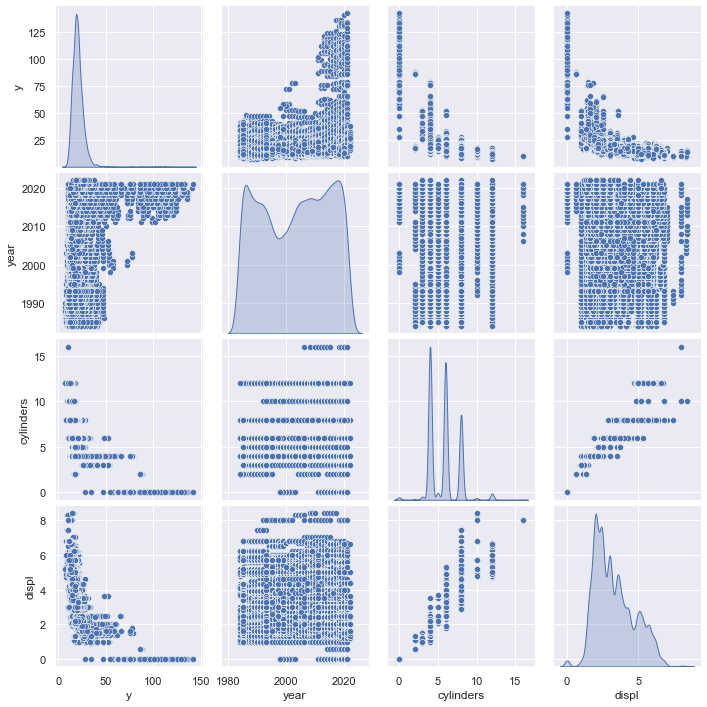

In [24]:
sns.pairplot(df1[['y', 'year', 'cylinders', 'displ']], diag_kind = 'kde');

In [25]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
y,42593.0,20.957672,8.686288,7.0,17.0,20.0,23.0,142.0
year,42593.0,2002.960111,11.474418,1984.0,1992.0,2004.0,2013.0,2022.0
cylinders,42593.0,5.687648,1.820314,0.0,4.0,6.0,6.0,16.0
displ,42593.0,3.274097,1.377733,0.0,2.2,3.0,4.3,8.4
ICE,42593.0,0.988402,0.107070,0.0,1.0,1.0,1.0,1.0
BEV,42593.0,0.006339,0.079366,0.0,0.0,0.0,0.0,1.0
PHEV,42593.0,0.005259,0.072329,0.0,0.0,0.0,0.0,1.0
phevBlended,42593.0,0.003827,0.061744,0.0,0.0,0.0,0.0,1.0
guzzler,42593.0,0.059423,0.236417,0.0,0.0,0.0,0.0,1.0
tCharger,42593.0,0.190501,0.392701,0.0,0.0,0.0,0.0,1.0


In [26]:
df.columns

Index(['y', 'year', 'make', 'model', 'cylinders', 'displ', 'drive', 'trany',
       'fuelType1', 'ICE', 'BEV', 'PHEV', 'VClass', 'phevBlended', 'guzzler',
       'tCharger', 'sCharger', 'startStop'],
      dtype='object')

#### One Hot Encoding Categorical Features

Next, we take our categorical features that remain and one hot encode them.  
The categorical features remaining in the dataset are the following columns:  
- **`drive`** 
- **`trany`** 
- **`fuelType1`** 
- **`VClass`**  
- **`cylinders`** — despite being having float values, the number of cylinders is discrete.
- **`year`** — instead of thinking of year as continuous, we can think of it as a class, as in vehicles from year 1990 belong to the 1990 category.

In [27]:
df1 = pd.get_dummies(df1, columns=['drive', 
                                  'trany', 
                                  'fuelType1', 
                                  'VClass', 
                                  'cylinders',
                                  'year'], drop_first = False)

In [28]:
len(df1.columns)

94

#### Creating Target and Predictor Variables

In [29]:
y = df1.y
X = df1.drop(labels='y', axis=1)

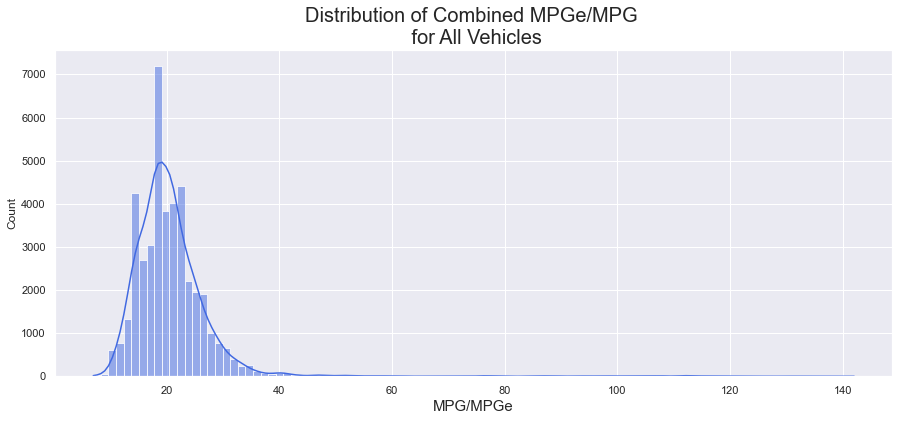

''

In [30]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Distribution of Combined MPGe/MPG \n for All Vehicles', size = 20)
sns.histplot(y, bins = 100, kde = True, color = 'royalblue')
ax.set_xlabel('MPG/MPGe', size=15)
# plt.savefig('images/phev_distA.png', transparent=True)
plt.show()
;

### Train/Test Split

In [39]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, random_state = 1984, test_size = 0.2)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state = 1984, test_size = 0.2)

X_train.shape

(27259, 93)

### Applying Scaling

In [40]:
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_val_sc = scaler.transform(X_valid)
X_test_sc = scaler.transform(X_test)

# Linear Regression

Before running Neural Networks, I run a simple Linear Regression model on the training data. The model performs on the validation set with a Root Mean Squared Error of 2.77, which we will compare with the evaluation metrics of our final Neural Network.

In [41]:
# instantiating a linear regression object
lm = LinearRegression()

# fitting the linear regression to the data
lm = lm.fit(X_train, y_train)

y_train_pred = lm.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

In [45]:
# Using fitted model to predict on test data
lr_y_preds = lm.predict(X_valid)

# We use sklearn's metrics package to evaluate the RMSE
test_rmse = np.sqrt(metrics.mean_squared_error(y_valid, lr_y_preds))

print('Validation Root Mean Squared Error:' , test_rmse)


print('Training Set RMSE: ', int(train_rmse), "vs. Validation Set RMSE: ", int(test_rmse))

Validation Root Mean Squared Error: 2.770979975628667
Training Set RMSE:  2 vs. Validation Set RMSE:  2


# Neural Network

## First Model

### Building & Results

#### Development

In [426]:
# Initializing a Sequential Model
model = Sequential()

# Adding Densely Connected Layers
model.add(Dense(30, activation = 'relu', input_shape = X_train_sc.shape[1:]))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(1))

# Compiling the Neural Network Model
model.compile(optimizer='Adam',
              loss='mse',
              metrics=['mae', 'mse'])

#### Results

In [431]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 30)                2820      
_________________________________________________________________
dense_19 (Dense)             (None, 8)                 248       
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 9         
Total params: 3,149
Trainable params: 3,149
Non-trainable params: 0
_________________________________________________________________


In [430]:
history = model.fit(X_train_sc, y_train, epochs=50, validation_data=(X_val_sc, y_valid), batch_size=10, verbose=1)

Epoch 1/50
2726/2726 [==============================] - 4s 1ms/step - loss: 5.1356 - mae: 1.4301 - mse: 5.1356 - val_loss: 5.0937 - val_mae: 1.4878 - val_mse: 5.0937
Epoch 2/50
2726/2726 [==============================] - 3s 1ms/step - loss: 4.7848 - mae: 1.3995 - mse: 4.7848 - val_loss: 4.9719 - val_mae: 1.4545 - val_mse: 4.9719
Epoch 3/50
2726/2726 [==============================] - 4s 1ms/step - loss: 4.5276 - mae: 1.3636 - mse: 4.5276 - val_loss: 4.6502 - val_mae: 1.4285 - val_mse: 4.6502
Epoch 4/50
2726/2726 [==============================] - 4s 2ms/step - loss: 4.3909 - mae: 1.3442 - mse: 4.3909 - val_loss: 4.2995 - val_mae: 1.3439 - val_mse: 4.2995
Epoch 5/50
2726/2726 [==============================] - 4s 1ms/step - loss: 4.2359 - mae: 1.3196 - mse: 4.2359 - val_loss: 4.7025 - val_mae: 1.3906 - val_mse: 4.7025
Epoch 6/50
2726/2726 [==============================] - 4s 1ms/step - loss: 4.1180 - mae: 1.2972 - mse: 4.1180 - val_loss: 4.3402 - val_mae: 1.3488 - val_mse: 4.3402
Epoc

In [437]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

In [625]:
hist

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,12.023142,1.936478,12.023142,5.941180,1.480917,5.941180,0
1,6.288750,1.521313,6.288750,5.954912,1.568315,5.954912,1
2,5.602259,1.428815,5.602259,5.576747,1.394690,5.576746,2
3,5.115333,1.356615,5.115333,4.759504,1.328014,4.759504,3
4,4.867369,1.303197,4.867369,4.084452,1.259703,4.084452,4
...,...,...,...,...,...,...,...
45,2.663136,0.955378,2.663136,2.907355,1.079898,2.907355,45
46,2.682484,0.954624,2.682484,2.967735,1.085312,2.967735,46
47,2.662591,0.946937,2.662591,2.934210,1.080935,2.934210,47
48,2.627759,0.943855,2.627759,3.258256,1.109244,3.258256,48


#### Visualization

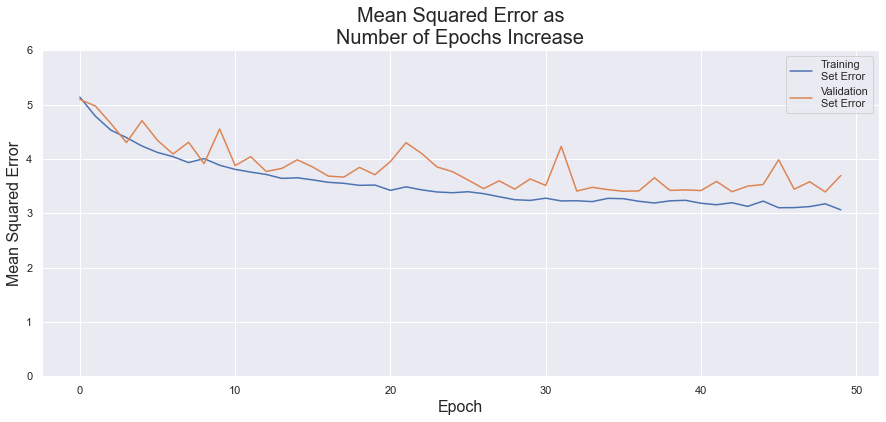

''

In [443]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Mean Squared Error as\nNumber of Epochs Increase', size = 20)
sns.lineplot(x = hist['epoch'], y = hist['mse'],
             label = 'Training\nSet Error')
sns.lineplot(x = hist['epoch'], y = hist['val_mse'],
            label = 'Validation\nSet Error')
plt.legend()
plt.ylim([0,6])

ax.set_xlabel('Epoch', size=16)
ax.set_ylabel('Mean Squared Error', size=16)
# plt.savefig('images/nn1A.png', transparent=True)
plt.show()
;

### Evaluation

In [46]:
np.sqrt(2.617959)

1.6180108157858526

- Upon inspection, our model did well enough to get predictions on the validation set down under a MSE of 4.
- Compared to our Linear Regression model, we are already doing better. The loss is an MSE of 2.62, which is an RMSE of 1.62. Our Linear Regression model performed with a RMSE of 2.78 on our validation set, for comparison.
- I'm a bit confused as to what is happening with the erratic spikes on the validations set, but it looks like we were beginning to see diminishing returns around 35 epochs, with the model scoring worse on the validation set several times after 44 epochs.
  - I would be interested in seeing what playing with our model parameters could do to bring our MSE down ever lower. Overall our model performs almost as well on the validation set as it does on the training set, so my first intuition would be parameter tuning.
  - The model as it stands now seems to be plateauing around a score of 3. Once I adjust parameters, hopefully we can get the MSE trend down and add additional epochs.
  - I have thoroughly cleaned the dataset, and with 44,000+ vehicles, exogenous data would be a late-stage luxury that I would love to consider later.

# Model 2

### Initialize Sequential Model

In [450]:
model_2 = Sequential()

### Adding Densely Connected Layers

I've added more to the input and hidden layers. This will certainly add training time to the model fit, however will likely produce better results than simply adding more hidden layers.

In [451]:
model_2.add(Dense(100, activation = 'relu', input_shape = X_train_sc.shape[1:]))
model_2.add(Dense(50, activation = 'relu'))
model_2.add(Dense(50, activation = 'relu'))
model_2.add(Dense(1))

### Compiling the Neural Network Model

I'm also going to try adding a different optimizer for this compiler. Adam is a good place to start, but let's see how bringing in and manually tuning one of the built in optimizers from keras works out.

In [452]:
optimum = optimizers.RMSprop(centered = True)

In [453]:
model_2.compile(optimizer=optimum,
              loss='mse',
              metrics=['mae', 'mse']) # left accuracy in there out of curiosity, but I'll be damned if I'm going to compile again just to remove that

In [455]:
model_2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 100)               9400      
_________________________________________________________________
dense_23 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_24 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 51        
Total params: 17,051
Trainable params: 17,051
Non-trainable params: 0
_________________________________________________________________


The new model has many more parameters than the first did, roughly 6 $\times$ as many. Let's see how it runs.

In [457]:
history2 = model_2.fit(X_train_sc, y_train, epochs=50, validation_data=(X_val_sc, y_valid), batch_size=10, verbose=1)

Epoch 1/50
2726/2726 [==============================] - 4s 2ms/step - loss: 12.0231 - mae: 1.9365 - mse: 12.0231 - val_loss: 5.9412 - val_mae: 1.4809 - val_mse: 5.9412
Epoch 2/50
2726/2726 [==============================] - 4s 2ms/step - loss: 6.2887 - mae: 1.5213 - mse: 6.2887 - val_loss: 5.9549 - val_mae: 1.5683 - val_mse: 5.9549
Epoch 3/50
2726/2726 [==============================] - 4s 2ms/step - loss: 5.6023 - mae: 1.4288 - mse: 5.6023 - val_loss: 5.5767 - val_mae: 1.3947 - val_mse: 5.5767
Epoch 4/50
2726/2726 [==============================] - 4s 1ms/step - loss: 5.1153 - mae: 1.3566 - mse: 5.1153 - val_loss: 4.7595 - val_mae: 1.3280 - val_mse: 4.7595
Epoch 5/50
2726/2726 [==============================] - 6s 2ms/step - loss: 4.8674 - mae: 1.3032 - mse: 4.8674 - val_loss: 4.0845 - val_mae: 1.2597 - val_mse: 4.0845
Epoch 6/50
2726/2726 [==============================] - 4s 2ms/step - loss: 4.4300 - mae: 1.2640 - mse: 4.4300 - val_loss: 4.2818 - val_mae: 1.2722 - val_mse: 4.2818
Ep

In [623]:
history.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x7fa2e7bd6490>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [5.135554790496826,
   4.784814357757568,
   4.5275797843933105,
   4.390861511230469,
   4.2358856201171875,
   4.117950916290283,
   4.040496826171875,
   3.93119215965271,
   4.005092620849609,
   3.882573127746582,
   3.806621789932251,
   3.756540536880493,
   3.7129147052764893,
   3.640946626663208,
   3.65189790725708,
   3.6131818294525146,
   3.5686933994293213,
   3.5499207973480225,
   3.513150453567505,
   3.5180814266204834,
   3.420698404312134,
   3.4847376346588135,
   3.430229425430298,
   3.3906848430633545,
   3.377133369445801,
   3.395120143890381,
   3.359579086303711,
   3.3035144805908203,
   3.248648166656494,
   3.235790252685547,
   3.276566982269287,
   3.2259328365325928,
   3.2291603088378906,
   3.213545799255371,
   3.2734315395355225,
   3.267285108566284,
   3.21958

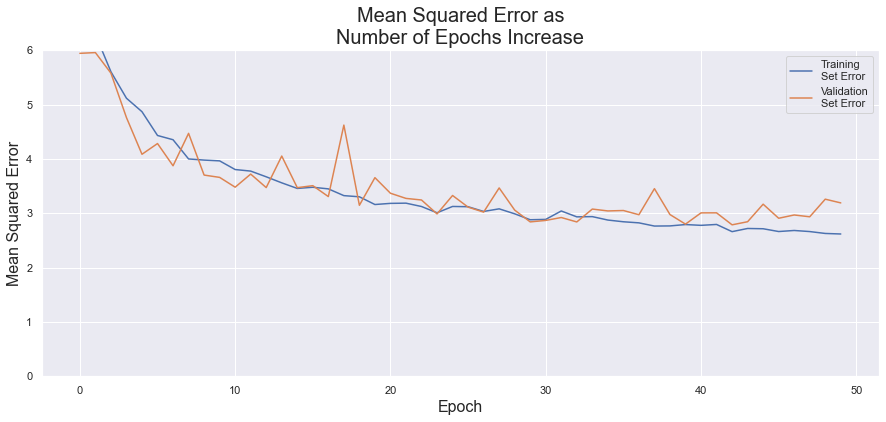

''

In [458]:
hist = pd.DataFrame(history2.history)
hist['epoch'] = history2.epoch

fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Mean Squared Error as\nNumber of Epochs Increase', size = 20)
sns.lineplot(x = hist['epoch'], y = hist['mse'],
             label = 'Training\nSet Error')
sns.lineplot(x = hist['epoch'], y = hist['val_mse'],
            label = 'Validation\nSet Error')
plt.legend()
plt.ylim([0,6])

ax.set_xlabel('Epoch', size=16)
ax.set_ylabel('Mean Squared Error', size=16)
# plt.savefig('images/nn1A.png', transparent=True)
plt.show()
;

### Model Evaluation

This model did slightly better, even getting the MSE score on the validation set below 3 at various points, but I was hoping the small model tuning I had implemented would have a larger effect.  
  
  For our next attempt, let's bring in `RandomizedSearchCV`.

# Neural Network Regression with Randomized Search

In [471]:
X_train_sc.shape[1:]

(93,)

Alright, if we want to be thorough, we're going to need a function that builds a neural network model.

In [599]:
def build_model(n_hidden = 1, n_neurons=30, learning_rate = 3e-3, optimizer = SGD(), input_shape=(93,)):
    """
    A function that takes in a bunch of stuff and outputs the best of the stuff!
    Builds a neural network for regression problems.
    
    ***parameters***
    n_hidden: input number of hidden layers 
        (default = 1)
    
    n_neurons: number of nodes per layer 
        (default = 30)
    
    learning_rate: user chosen learning rate 
        (default = .003)
    
    optimizers: specified optimizer, such as Adam, SGD, or RMSProp 
        (default = SGD)
    
    """
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation = 'relu'))
    model.add(Dense(1))
    optimizers = optimizer
    model.compile(loss = 'mse', metrics=['mae', 'mse'])
    return model

Now let's build a wrapper for our new function.

In [600]:
keras_reg = KerasRegressor(build_model)

Finally, let's use our neat wrapper object to train many models.

Below we establish a parameter dictionary. The RandomizedSearch object will take the parameters run many models using a number of combinations.

In [601]:
# params

In [602]:
print(tf.__version__)

2.3.1


In [603]:
params = {
    'n_hidden': (0, 1, 2, 3), # creating a range for possible numbers of hidden layers
    'n_neurons': tuple(range(1,100)), # creating a range for number of nodes per layer
    'learning_rate': (3e-4, 3e-3, 3e-2), 
    'optimizer': ('Adam', 'SGD', 'RMSprop')
                    
}

rando_cv = RandomizedSearchCV(keras_reg, 
                              params,
                              n_iter = 10, 
                              cv = 3)

rando_cv.fit(X_train_sc, y_train, epochs = 100,
            validation_data = (X_val_sc, y_valid),
            callbacks = [EarlyStopping(patience = 10)])

Epoch 1/100
568/568 [==============================] - 1s 1ms/step - loss: 495.9272 - mae: 20.7195 - mse: 495.9272 - val_loss: 460.0229 - val_mae: 20.3274 - val_mse: 460.0229
Epoch 2/100
568/568 [==============================] - 1s 1ms/step - loss: 457.9903 - mae: 20.1472 - mse: 457.9903 - val_loss: 428.3760 - val_mae: 19.7681 - val_mse: 428.3760
Epoch 3/100
568/568 [==============================] - 1s 1ms/step - loss: 426.5968 - mae: 19.5745 - mse: 426.5968 - val_loss: 400.8940 - val_mae: 19.2077 - val_mse: 400.8940
Epoch 4/100
568/568 [==============================] - 1s 1ms/step - loss: 398.1047 - mae: 19.0008 - mse: 398.1047 - val_loss: 376.1333 - val_mae: 18.6502 - val_mse: 376.1333
Epoch 5/100
568/568 [==============================] - 1s 1ms/step - loss: 372.5907 - mae: 18.4309 - mse: 372.5907 - val_loss: 353.4352 - val_mae: 18.0895 - val_mse: 353.4352
Epoch 6/100
568/568 [==============================] - 1s 1ms/step - loss: 349.7327 - mae: 17.8646 - mse: 349.7327 - val_loss

568/568 [==============================] - 1s 1ms/step - loss: 48.1613 - mae: 1.8152 - mse: 48.1613 - val_loss: 39.6976 - val_mae: 1.8156 - val_mse: 39.6976
Epoch 97/100
568/568 [==============================] - 1s 1ms/step - loss: 47.7502 - mae: 1.8152 - mse: 47.7502 - val_loss: 39.2969 - val_mae: 1.8120 - val_mse: 39.2969
Epoch 98/100
568/568 [==============================] - 1s 3ms/step - loss: 47.3041 - mae: 1.8148 - mse: 47.3041 - val_loss: 38.8833 - val_mae: 1.8143 - val_mse: 38.8833
Epoch 99/100
568/568 [==============================] - 1s 2ms/step - loss: 46.9699 - mae: 1.8148 - mse: 46.9699 - val_loss: 38.5671 - val_mae: 1.8145 - val_mse: 38.5671
Epoch 100/100
284/284 [==============================] - 0s 2ms/step - loss: 14.4946 - mae: 1.7029 - mse: 14.4946
Epoch 1/100
568/568 [==============================] - 1s 2ms/step - loss: 506.1071 - mae: 20.6843 - mse: 506.1071 - val_loss: 469.5828 - val_mae: 20.3234 - val_mse: 469.5828
Epoch 2/100
568/568 [=======================

Epoch 2/100
568/568 [==============================] - 1s 2ms/step - loss: 451.8082 - mae: 20.0517 - mse: 451.8082 - val_loss: 427.9534 - val_mae: 19.7456 - val_mse: 427.9534
Epoch 3/100
568/568 [==============================] - 1s 2ms/step - loss: 420.1671 - mae: 19.4879 - mse: 420.1671 - val_loss: 401.2636 - val_mae: 19.1882 - val_mse: 401.2636
Epoch 4/100
568/568 [==============================] - 1s 1ms/step - loss: 393.2506 - mae: 18.9153 - mse: 393.2506 - val_loss: 377.6659 - val_mae: 18.6332 - val_mse: 377.6659
Epoch 5/100
568/568 [==============================] - 1s 1ms/step - loss: 368.9946 - mae: 18.3523 - mse: 368.9946 - val_loss: 356.4709 - val_mae: 18.0764 - val_mse: 356.4709
Epoch 6/100
568/568 [==============================] - 1s 1ms/step - loss: 346.6642 - mae: 17.7849 - mse: 346.6642 - val_loss: 336.9370 - val_mae: 17.5196 - val_mse: 336.9370
Epoch 7/100
568/568 [==============================] - 1s 1ms/step - loss: 326.0635 - mae: 17.2195 - mse: 326.0635 - val_loss

Epoch 59/100
568/568 [==============================] - 1s 1ms/step - loss: 74.6004 - mae: 1.8710 - mse: 74.6004 - val_loss: 66.2839 - val_mae: 1.8731 - val_mse: 66.2839
Epoch 60/100
568/568 [==============================] - 1s 1ms/step - loss: 73.9926 - mae: 1.8694 - mse: 73.9926 - val_loss: 65.7103 - val_mae: 1.8712 - val_mse: 65.7103
Epoch 61/100
568/568 [==============================] - 1s 1ms/step - loss: 73.3618 - mae: 1.8644 - mse: 73.3618 - val_loss: 65.0842 - val_mae: 1.8714 - val_mse: 65.0842
Epoch 62/100
568/568 [==============================] - 1s 1ms/step - loss: 72.7935 - mae: 1.8644 - mse: 72.7935 - val_loss: 64.5707 - val_mae: 1.8734 - val_mse: 64.5707
Epoch 63/100
568/568 [==============================] - 1s 1ms/step - loss: 72.4380 - mae: 1.8664 - mse: 72.4380 - val_loss: 64.2926 - val_mae: 1.8705 - val_mse: 64.2926
Epoch 64/100
568/568 [==============================] - 1s 1ms/step - loss: 72.0339 - mae: 1.8623 - mse: 72.0339 - val_loss: 63.7310 - val_mae: 1.8741

568/568 [==============================] - 1s 1ms/step - loss: 274.8104 - mae: 15.5163 - mse: 274.8104 - val_loss: 276.8686 - val_mae: 15.2857 - val_mse: 276.8686
Epoch 11/100
568/568 [==============================] - 1s 1ms/step - loss: 258.2360 - mae: 14.9475 - mse: 258.2360 - val_loss: 263.0221 - val_mae: 14.7300 - val_mse: 263.0221
Epoch 12/100
568/568 [==============================] - 1s 2ms/step - loss: 243.4978 - mae: 14.3829 - mse: 243.4978 - val_loss: 252.3475 - val_mae: 14.1761 - val_mse: 252.3475
Epoch 13/100
568/568 [==============================] - 1s 2ms/step - loss: 229.2171 - mae: 13.8204 - mse: 229.2171 - val_loss: 239.5181 - val_mae: 13.6177 - val_mse: 239.5181
Epoch 14/100
568/568 [==============================] - 1s 2ms/step - loss: 216.4116 - mae: 13.2548 - mse: 216.4116 - val_loss: 229.1610 - val_mae: 13.0595 - val_mse: 229.1610
Epoch 15/100
568/568 [==============================] - 1s 2ms/step - loss: 203.3521 - mae: 12.6936 - mse: 203.3521 - val_loss: 221.5

Epoch 21/100
568/568 [==============================] - 1s 1ms/step - loss: 138.0324 - mae: 9.4275 - mse: 138.0324 - val_loss: 132.2451 - val_mae: 9.1482 - val_mse: 132.2451
Epoch 22/100
568/568 [==============================] - 1s 1ms/step - loss: 130.9978 - mae: 8.8708 - mse: 130.9978 - val_loss: 124.3488 - val_mae: 8.5922 - val_mse: 124.3488
Epoch 23/100
568/568 [==============================] - 1s 1ms/step - loss: 123.2157 - mae: 8.3147 - mse: 123.2157 - val_loss: 117.2320 - val_mae: 8.0305 - val_mse: 117.2320
Epoch 24/100
568/568 [==============================] - 1s 2ms/step - loss: 117.6688 - mae: 7.7569 - mse: 117.6688 - val_loss: 109.7988 - val_mae: 7.4756 - val_mse: 109.7988
Epoch 25/100
568/568 [==============================] - 1s 2ms/step - loss: 109.9635 - mae: 7.2044 - mse: 109.9635 - val_loss: 102.4246 - val_mae: 6.9263 - val_mse: 102.4246
Epoch 26/100
568/568 [==============================] - 1s 2ms/step - loss: 102.6168 - mae: 6.6559 - mse: 102.6168 - val_loss: 96.

568/568 [==============================] - 1s 2ms/step - loss: 65.6784 - mae: 1.8501 - mse: 65.6784 - val_loss: 55.0183 - val_mae: 1.8503 - val_mse: 55.0183
Epoch 70/100
568/568 [==============================] - 1s 1ms/step - loss: 65.1904 - mae: 1.8493 - mse: 65.1904 - val_loss: 54.5514 - val_mae: 1.8443 - val_mse: 54.5514
Epoch 71/100
568/568 [==============================] - 1s 1ms/step - loss: 64.6034 - mae: 1.8442 - mse: 64.6034 - val_loss: 54.0855 - val_mae: 1.8447 - val_mse: 54.0855
Epoch 72/100
568/568 [==============================] - 1s 1ms/step - loss: 64.1357 - mae: 1.8442 - mse: 64.1357 - val_loss: 53.5947 - val_mae: 1.8453 - val_mse: 53.5947
Epoch 73/100
568/568 [==============================] - 1s 1ms/step - loss: 63.5174 - mae: 1.8455 - mse: 63.5174 - val_loss: 53.1598 - val_mae: 1.8437 - val_mse: 53.1598
Epoch 74/100
568/568 [==============================] - 1s 1ms/step - loss: 63.0634 - mae: 1.8435 - mse: 63.0634 - val_loss: 52.6763 - val_mae: 1.8443 - val_mse: 5

568/568 [==============================] - 1s 2ms/step - loss: 147.7522 - mae: 9.3238 - mse: 147.7522 - val_loss: 176.6779 - val_mae: 9.1582 - val_mse: 176.6779
Epoch 22/100
568/568 [==============================] - 2s 3ms/step - loss: 141.3960 - mae: 8.7668 - mse: 141.3960 - val_loss: 173.4756 - val_mae: 8.6003 - val_mse: 173.4756
Epoch 23/100
568/568 [==============================] - 1s 2ms/step - loss: 134.4163 - mae: 8.2060 - mse: 134.4163 - val_loss: 169.8081 - val_mae: 8.0431 - val_mse: 169.8081
Epoch 24/100
568/568 [==============================] - 1s 3ms/step - loss: 129.6190 - mae: 7.6465 - mse: 129.6190 - val_loss: 167.4233 - val_mae: 7.4905 - val_mse: 167.4233
Epoch 25/100
568/568 [==============================] - 1s 2ms/step - loss: 127.3901 - mae: 7.0910 - mse: 127.3901 - val_loss: 166.8237 - val_mae: 6.9423 - val_mse: 166.8237
Epoch 26/100
568/568 [==============================] - 2s 3ms/step - loss: 121.8745 - mae: 6.5444 - mse: 121.8745 - val_loss: 166.5712 - val_m

Epoch 18/100
568/568 [==============================] - 1s 2ms/step - loss: 4.0945 - mae: 1.2456 - mse: 4.0945 - val_loss: 4.6926 - val_mae: 1.3717 - val_mse: 4.6926
Epoch 19/100
568/568 [==============================] - 1s 2ms/step - loss: 4.0909 - mae: 1.2403 - mse: 4.0909 - val_loss: 4.3989 - val_mae: 1.3278 - val_mse: 4.3989
Epoch 20/100
568/568 [==============================] - 1s 2ms/step - loss: 3.9398 - mae: 1.2304 - mse: 3.9398 - val_loss: 4.4892 - val_mae: 1.3353 - val_mse: 4.4892
Epoch 21/100
568/568 [==============================] - 1s 3ms/step - loss: 3.8691 - mae: 1.2161 - mse: 3.8691 - val_loss: 4.7505 - val_mae: 1.3864 - val_mse: 4.7505
Epoch 22/100
568/568 [==============================] - 1s 2ms/step - loss: 4.0049 - mae: 1.2186 - mse: 4.0049 - val_loss: 4.1453 - val_mae: 1.3156 - val_mse: 4.1453
Epoch 23/100
568/568 [==============================] - 1s 2ms/step - loss: 3.7369 - mae: 1.2113 - mse: 3.7369 - val_loss: 4.1075 - val_mae: 1.3018 - val_mse: 4.1075
Epoc

Epoch 36/100
568/568 [==============================] - 1s 2ms/step - loss: 3.0842 - mae: 1.1209 - mse: 3.0842 - val_loss: 4.0385 - val_mae: 1.2686 - val_mse: 4.0385
Epoch 37/100
568/568 [==============================] - 2s 3ms/step - loss: 3.1434 - mae: 1.1167 - mse: 3.1434 - val_loss: 3.7861 - val_mae: 1.2505 - val_mse: 3.7861
Epoch 38/100
568/568 [==============================] - 2s 3ms/step - loss: 3.0197 - mae: 1.1082 - mse: 3.0197 - val_loss: 4.0171 - val_mae: 1.2753 - val_mse: 4.0171
Epoch 39/100
568/568 [==============================] - 1s 3ms/step - loss: 3.0799 - mae: 1.1101 - mse: 3.0799 - val_loss: 3.6808 - val_mae: 1.2419 - val_mse: 3.6808
Epoch 40/100
568/568 [==============================] - 1s 2ms/step - loss: 3.0549 - mae: 1.1011 - mse: 3.0549 - val_loss: 3.8509 - val_mae: 1.2426 - val_mse: 3.8509
Epoch 41/100
568/568 [==============================] - 1s 2ms/step - loss: 3.0574 - mae: 1.1038 - mse: 3.0574 - val_loss: 3.8152 - val_mae: 1.2679 - val_mse: 3.8152
Epoc

Epoch 36/100
568/568 [==============================] - 1s 2ms/step - loss: 3.5388 - mae: 1.1676 - mse: 3.5388 - val_loss: 4.6987 - val_mae: 1.2667 - val_mse: 4.6987
Epoch 37/100
568/568 [==============================] - 1s 2ms/step - loss: 3.5373 - mae: 1.1664 - mse: 3.5373 - val_loss: 4.0563 - val_mae: 1.2614 - val_mse: 4.0563
Epoch 38/100
568/568 [==============================] - 1s 2ms/step - loss: 3.5476 - mae: 1.1621 - mse: 3.5476 - val_loss: 4.3572 - val_mae: 1.2950 - val_mse: 4.3572
Epoch 39/100
568/568 [==============================] - 1s 2ms/step - loss: 3.5224 - mae: 1.1602 - mse: 3.5224 - val_loss: 4.5514 - val_mae: 1.4104 - val_mse: 4.5514
Epoch 40/100
568/568 [==============================] - 1s 3ms/step - loss: 3.4208 - mae: 1.1545 - mse: 3.4208 - val_loss: 4.6014 - val_mae: 1.3246 - val_mse: 4.6014
Epoch 41/100
568/568 [==============================] - 2s 3ms/step - loss: 3.4398 - mae: 1.1480 - mse: 3.4398 - val_loss: 3.9167 - val_mae: 1.2336 - val_mse: 3.9167
Epoc

Epoch 16/100
568/568 [==============================] - 1s 2ms/step - loss: 4.5442 - mae: 1.3155 - mse: 4.5442 - val_loss: 4.8204 - val_mae: 1.3640 - val_mse: 4.8204
Epoch 17/100
568/568 [==============================] - 1s 2ms/step - loss: 4.4552 - mae: 1.2997 - mse: 4.4552 - val_loss: 4.6881 - val_mae: 1.3974 - val_mse: 4.6881
Epoch 18/100
568/568 [==============================] - 1s 2ms/step - loss: 4.3750 - mae: 1.2911 - mse: 4.3750 - val_loss: 4.6543 - val_mae: 1.3614 - val_mse: 4.6543
Epoch 19/100
568/568 [==============================] - 1s 2ms/step - loss: 4.3351 - mae: 1.2850 - mse: 4.3351 - val_loss: 4.5293 - val_mae: 1.3632 - val_mse: 4.5293
Epoch 20/100
568/568 [==============================] - 1s 2ms/step - loss: 4.2331 - mae: 1.2755 - mse: 4.2331 - val_loss: 4.5929 - val_mae: 1.3641 - val_mse: 4.5929
Epoch 21/100
568/568 [==============================] - 1s 2ms/step - loss: 4.2845 - mae: 1.2743 - mse: 4.2845 - val_loss: 4.7763 - val_mae: 1.3615 - val_mse: 4.7763
Epoc

Epoch 46/100
568/568 [==============================] - 1s 2ms/step - loss: 3.4471 - mae: 1.1542 - mse: 3.4471 - val_loss: 4.4083 - val_mae: 1.4017 - val_mse: 4.4083
Epoch 47/100
568/568 [==============================] - 1s 1ms/step - loss: 3.4844 - mae: 1.1569 - mse: 3.4844 - val_loss: 4.3554 - val_mae: 1.3688 - val_mse: 4.3554
Epoch 48/100
568/568 [==============================] - 1s 1ms/step - loss: 3.4757 - mae: 1.1542 - mse: 3.4757 - val_loss: 4.4520 - val_mae: 1.3531 - val_mse: 4.4520
Epoch 49/100
568/568 [==============================] - 1s 1ms/step - loss: 3.3931 - mae: 1.1502 - mse: 3.3931 - val_loss: 3.9989 - val_mae: 1.2790 - val_mse: 3.9989
Epoch 50/100
568/568 [==============================] - 1s 1ms/step - loss: 3.4464 - mae: 1.1472 - mse: 3.4464 - val_loss: 3.8310 - val_mae: 1.2684 - val_mse: 3.8310
Epoch 51/100
568/568 [==============================] - 1s 1ms/step - loss: 3.4346 - mae: 1.1445 - mse: 3.4346 - val_loss: 3.7530 - val_mae: 1.2609 - val_mse: 3.7530
Epoc

Epoch 23/100
568/568 [==============================] - 1s 1ms/step - loss: 3.1392 - mae: 1.0757 - mse: 3.1392 - val_loss: 4.2146 - val_mae: 1.2519 - val_mse: 4.2146
Epoch 24/100
568/568 [==============================] - 1s 1ms/step - loss: 3.1207 - mae: 1.0714 - mse: 3.1207 - val_loss: 4.1676 - val_mae: 1.2616 - val_mse: 4.1676
Epoch 25/100
568/568 [==============================] - 1s 1ms/step - loss: 3.0961 - mae: 1.0687 - mse: 3.0961 - val_loss: 4.0571 - val_mae: 1.2396 - val_mse: 4.0571
Epoch 26/100
568/568 [==============================] - 1s 1ms/step - loss: 3.0637 - mae: 1.0658 - mse: 3.0637 - val_loss: 3.9591 - val_mae: 1.2171 - val_mse: 3.9591
Epoch 27/100
568/568 [==============================] - 1s 1ms/step - loss: 2.9969 - mae: 1.0592 - mse: 2.9969 - val_loss: 4.1900 - val_mae: 1.2325 - val_mse: 4.1900
Epoch 28/100
568/568 [==============================] - 1s 1ms/step - loss: 2.9824 - mae: 1.0533 - mse: 2.9824 - val_loss: 3.9493 - val_mae: 1.2228 - val_mse: 3.9493
Epoc

Epoch 21/100
568/568 [==============================] - 1s 2ms/step - loss: 3.4068 - mae: 1.0996 - mse: 3.4068 - val_loss: 3.8308 - val_mae: 1.2322 - val_mse: 3.8308
Epoch 22/100
568/568 [==============================] - 1s 2ms/step - loss: 3.3490 - mae: 1.0953 - mse: 3.3490 - val_loss: 4.1355 - val_mae: 1.2434 - val_mse: 4.1355
Epoch 23/100
568/568 [==============================] - 1s 2ms/step - loss: 3.3786 - mae: 1.0875 - mse: 3.3786 - val_loss: 3.8180 - val_mae: 1.2400 - val_mse: 3.8180
Epoch 24/100
568/568 [==============================] - 2s 3ms/step - loss: 3.3415 - mae: 1.0830 - mse: 3.3415 - val_loss: 3.7332 - val_mae: 1.2241 - val_mse: 3.7332
Epoch 25/100
568/568 [==============================] - 1s 2ms/step - loss: 3.3101 - mae: 1.0783 - mse: 3.3101 - val_loss: 3.7317 - val_mae: 1.2379 - val_mse: 3.7317
Epoch 26/100
568/568 [==============================] - 1s 2ms/step - loss: 3.2455 - mae: 1.0737 - mse: 3.2455 - val_loss: 3.9147 - val_mae: 1.2376 - val_mse: 3.9147
Epoc

Epoch 18/100
568/568 [==============================] - 1s 1ms/step - loss: 3.5691 - mae: 1.1151 - mse: 3.5691 - val_loss: 4.2393 - val_mae: 1.2603 - val_mse: 4.2393
Epoch 19/100
568/568 [==============================] - 1s 1ms/step - loss: 3.4844 - mae: 1.1065 - mse: 3.4844 - val_loss: 4.2207 - val_mae: 1.2538 - val_mse: 4.2207
Epoch 20/100
568/568 [==============================] - 1s 1ms/step - loss: 3.4799 - mae: 1.1028 - mse: 3.4799 - val_loss: 4.0490 - val_mae: 1.2464 - val_mse: 4.0490
Epoch 21/100
568/568 [==============================] - 1s 1ms/step - loss: 3.3356 - mae: 1.0938 - mse: 3.3356 - val_loss: 3.9837 - val_mae: 1.2392 - val_mse: 3.9837
Epoch 22/100
568/568 [==============================] - 1s 1ms/step - loss: 3.3325 - mae: 1.0871 - mse: 3.3325 - val_loss: 4.0277 - val_mae: 1.2608 - val_mse: 4.0277
Epoch 23/100
568/568 [==============================] - 1s 1ms/step - loss: 3.3285 - mae: 1.0820 - mse: 3.3285 - val_loss: 4.0072 - val_mae: 1.2624 - val_mse: 4.0072
Epoc

Epoch 22/100
568/568 [==============================] - 1s 3ms/step - loss: 3.2561 - mae: 1.1239 - mse: 3.2561 - val_loss: 4.1189 - val_mae: 1.3037 - val_mse: 4.1189
Epoch 23/100
568/568 [==============================] - 1s 2ms/step - loss: 3.1576 - mae: 1.1164 - mse: 3.1576 - val_loss: 4.1613 - val_mae: 1.3097 - val_mse: 4.1613
Epoch 24/100
568/568 [==============================] - 1s 1ms/step - loss: 3.3021 - mae: 1.1189 - mse: 3.3021 - val_loss: 4.1992 - val_mae: 1.3132 - val_mse: 4.1992
Epoch 25/100
568/568 [==============================] - 1s 1ms/step - loss: 3.1873 - mae: 1.1135 - mse: 3.1873 - val_loss: 4.0515 - val_mae: 1.2863 - val_mse: 4.0515
Epoch 26/100
568/568 [==============================] - 1s 2ms/step - loss: 3.1822 - mae: 1.1061 - mse: 3.1822 - val_loss: 3.9609 - val_mae: 1.2778 - val_mse: 3.9609
Epoch 27/100
568/568 [==============================] - 1s 2ms/step - loss: 3.1875 - mae: 1.0980 - mse: 3.1875 - val_loss: 4.5702 - val_mae: 1.4016 - val_mse: 4.5702
Epoc

Epoch 13/100
568/568 [==============================] - 1s 2ms/step - loss: 4.1408 - mae: 1.2072 - mse: 4.1408 - val_loss: 4.6562 - val_mae: 1.3994 - val_mse: 4.6562
Epoch 14/100
568/568 [==============================] - 1s 1ms/step - loss: 3.8909 - mae: 1.1853 - mse: 3.8909 - val_loss: 5.1889 - val_mae: 1.5451 - val_mse: 5.1889
Epoch 15/100
568/568 [==============================] - 1s 1ms/step - loss: 3.8979 - mae: 1.1666 - mse: 3.8979 - val_loss: 4.4349 - val_mae: 1.2924 - val_mse: 4.4349
Epoch 16/100
568/568 [==============================] - 1s 2ms/step - loss: 3.8357 - mae: 1.1612 - mse: 3.8357 - val_loss: 5.6029 - val_mae: 1.4392 - val_mse: 5.6029
Epoch 17/100
568/568 [==============================] - 1s 2ms/step - loss: 3.8025 - mae: 1.1516 - mse: 3.8025 - val_loss: 4.3064 - val_mae: 1.2935 - val_mse: 4.3064
Epoch 18/100
568/568 [==============================] - 1s 2ms/step - loss: 3.6942 - mae: 1.1464 - mse: 3.6942 - val_loss: 4.0684 - val_mae: 1.2812 - val_mse: 4.0684
Epoc

Epoch 13/100
568/568 [==============================] - 1s 1ms/step - loss: 222.8941 - mae: 13.9012 - mse: 222.8941 - val_loss: 214.2489 - val_mae: 13.6166 - val_mse: 214.2489
Epoch 14/100
568/568 [==============================] - 1s 1ms/step - loss: 209.6978 - mae: 13.3406 - mse: 209.6978 - val_loss: 201.1902 - val_mae: 13.0601 - val_mse: 201.1902
Epoch 15/100
568/568 [==============================] - 1s 1ms/step - loss: 197.2907 - mae: 12.7820 - mse: 197.2907 - val_loss: 189.0396 - val_mae: 12.5002 - val_mse: 189.0396
Epoch 16/100
568/568 [==============================] - 1s 1ms/step - loss: 183.7786 - mae: 12.2199 - mse: 183.7786 - val_loss: 176.6896 - val_mae: 11.9412 - val_mse: 176.6896
Epoch 17/100
568/568 [==============================] - 1s 1ms/step - loss: 173.7989 - mae: 11.6608 - mse: 173.7989 - val_loss: 165.6951 - val_mae: 11.3802 - val_mse: 165.6951
Epoch 18/100
568/568 [==============================] - 1s 1ms/step - loss: 162.9240 - mae: 11.1014 - mse: 162.9240 - va

Epoch 61/100
568/568 [==============================] - 1s 1ms/step - loss: 67.6885 - mae: 1.8551 - mse: 67.6885 - val_loss: 58.2609 - val_mae: 1.8560 - val_mse: 58.2609
Epoch 62/100
568/568 [==============================] - 1s 1ms/step - loss: 66.9622 - mae: 1.8533 - mse: 66.9622 - val_loss: 57.5903 - val_mae: 1.8558 - val_mse: 57.5903
Epoch 63/100
568/568 [==============================] - 1s 1ms/step - loss: 66.2532 - mae: 1.8519 - mse: 66.2532 - val_loss: 57.0417 - val_mae: 1.8540 - val_mse: 57.0417
Epoch 64/100
568/568 [==============================] - 1s 1ms/step - loss: 65.6425 - mae: 1.8518 - mse: 65.6425 - val_loss: 56.3966 - val_mae: 1.8501 - val_mse: 56.3966
Epoch 65/100
568/568 [==============================] - 1s 3ms/step - loss: 64.9940 - mae: 1.8483 - mse: 64.9940 - val_loss: 55.9386 - val_mae: 1.8516 - val_mse: 55.9386
Epoch 66/100
568/568 [==============================] - 1s 2ms/step - loss: 64.4751 - mae: 1.8492 - mse: 64.4751 - val_loss: 55.1981 - val_mae: 1.8487

568/568 [==============================] - 1s 1ms/step - loss: 200.5421 - mae: 12.6951 - mse: 200.5421 - val_loss: 214.5247 - val_mae: 12.5022 - val_mse: 214.5247
Epoch 16/100
568/568 [==============================] - 1s 1ms/step - loss: 189.2191 - mae: 12.1304 - mse: 189.2191 - val_loss: 205.4315 - val_mae: 11.9450 - val_mse: 205.4315
Epoch 17/100
568/568 [==============================] - 1s 1ms/step - loss: 179.1930 - mae: 11.5691 - mse: 179.1930 - val_loss: 197.2272 - val_mae: 11.3859 - val_mse: 197.2272
Epoch 18/100
568/568 [==============================] - 1s 1ms/step - loss: 169.1877 - mae: 11.0064 - mse: 169.1877 - val_loss: 189.4789 - val_mae: 10.8268 - val_mse: 189.4789
Epoch 19/100
568/568 [==============================] - 1s 1ms/step - loss: 161.6610 - mae: 10.4460 - mse: 161.6610 - val_loss: 185.8323 - val_mae: 10.2708 - val_mse: 185.8323
Epoch 20/100
568/568 [==============================] - 1s 1ms/step - loss: 154.8950 - mae: 9.8821 - mse: 154.8950 - val_loss: 180.48

Epoch 28/100
568/568 [==============================] - 1s 1ms/step - loss: 3.6385 - mae: 1.1963 - mse: 3.6385 - val_loss: 4.4416 - val_mae: 1.3164 - val_mse: 4.4416
Epoch 29/100
568/568 [==============================] - 1s 1ms/step - loss: 3.6329 - mae: 1.1933 - mse: 3.6329 - val_loss: 4.4633 - val_mae: 1.3225 - val_mse: 4.4633
Epoch 30/100
568/568 [==============================] - 1s 1ms/step - loss: 3.5940 - mae: 1.1920 - mse: 3.5940 - val_loss: 4.3486 - val_mae: 1.3009 - val_mse: 4.3486
Epoch 31/100
568/568 [==============================] - 1s 1ms/step - loss: 3.5841 - mae: 1.1874 - mse: 3.5841 - val_loss: 4.3623 - val_mae: 1.3096 - val_mse: 4.3623
Epoch 32/100
568/568 [==============================] - 1s 1ms/step - loss: 3.5686 - mae: 1.1864 - mse: 3.5686 - val_loss: 4.3573 - val_mae: 1.3076 - val_mse: 4.3573
Epoch 33/100
568/568 [==============================] - 1s 1ms/step - loss: 3.4960 - mae: 1.1789 - mse: 3.4960 - val_loss: 4.3307 - val_mae: 1.3007 - val_mse: 4.3307
Epoc

Epoch 26/100
568/568 [==============================] - 1s 1ms/step - loss: 4.1114 - mae: 1.2091 - mse: 4.1114 - val_loss: 4.3574 - val_mae: 1.2956 - val_mse: 4.3574
Epoch 27/100
568/568 [==============================] - 1s 1ms/step - loss: 4.1064 - mae: 1.2034 - mse: 4.1064 - val_loss: 4.4167 - val_mae: 1.2993 - val_mse: 4.4167
Epoch 28/100
568/568 [==============================] - 1s 1ms/step - loss: 4.0969 - mae: 1.1979 - mse: 4.0969 - val_loss: 4.3688 - val_mae: 1.2851 - val_mse: 4.3688
Epoch 29/100
568/568 [==============================] - 1s 1ms/step - loss: 4.0288 - mae: 1.1954 - mse: 4.0288 - val_loss: 4.2766 - val_mae: 1.2766 - val_mse: 4.2766
Epoch 30/100
568/568 [==============================] - 1s 1ms/step - loss: 3.9760 - mae: 1.1935 - mse: 3.9760 - val_loss: 4.3973 - val_mae: 1.2970 - val_mse: 4.3973
Epoch 31/100
568/568 [==============================] - 1s 1ms/step - loss: 3.9745 - mae: 1.1859 - mse: 3.9745 - val_loss: 4.2762 - val_mae: 1.2914 - val_mse: 4.2762
Epoc

Epoch 24/100
568/568 [==============================] - 1s 1ms/step - loss: 4.8381 - mae: 1.2387 - mse: 4.8381 - val_loss: 5.1265 - val_mae: 1.3276 - val_mse: 5.1265
Epoch 25/100
568/568 [==============================] - 1s 1ms/step - loss: 4.7218 - mae: 1.2330 - mse: 4.7218 - val_loss: 5.0069 - val_mae: 1.3206 - val_mse: 5.0069
Epoch 26/100
568/568 [==============================] - 1s 1ms/step - loss: 4.5700 - mae: 1.2292 - mse: 4.5700 - val_loss: 4.9786 - val_mae: 1.3296 - val_mse: 4.9786
Epoch 27/100
568/568 [==============================] - 1s 1ms/step - loss: 4.5072 - mae: 1.2216 - mse: 4.5072 - val_loss: 4.7980 - val_mae: 1.3170 - val_mse: 4.7980
Epoch 28/100
568/568 [==============================] - 1s 1ms/step - loss: 4.3967 - mae: 1.2181 - mse: 4.3967 - val_loss: 4.7455 - val_mae: 1.3123 - val_mse: 4.7455
Epoch 29/100
568/568 [==============================] - 1s 1ms/step - loss: 4.2884 - mae: 1.2135 - mse: 4.2884 - val_loss: 4.7117 - val_mae: 1.3191 - val_mse: 4.7117
Epoc

568/568 [==============================] - 1s 1ms/step - loss: 83.9565 - mae: 1.9639 - mse: 83.9565 - val_loss: 71.7948 - val_mae: 1.9649 - val_mse: 71.7948
Epoch 40/100
568/568 [==============================] - 1s 1ms/step - loss: 83.3633 - mae: 1.9448 - mse: 83.3633 - val_loss: 71.4467 - val_mae: 1.9500 - val_mse: 71.4467
Epoch 41/100
568/568 [==============================] - 1s 1ms/step - loss: 82.8900 - mae: 1.9346 - mse: 82.8900 - val_loss: 70.8288 - val_mae: 1.9414 - val_mse: 70.8288
Epoch 42/100
568/568 [==============================] - 1s 1ms/step - loss: 82.2933 - mae: 1.9257 - mse: 82.2933 - val_loss: 70.1695 - val_mae: 1.9346 - val_mse: 70.1695
Epoch 43/100
568/568 [==============================] - 1s 1ms/step - loss: 81.6131 - mae: 1.9200 - mse: 81.6131 - val_loss: 69.4787 - val_mae: 1.9315 - val_mse: 69.4787
Epoch 44/100
568/568 [==============================] - 1s 1ms/step - loss: 80.8880 - mae: 1.9182 - mse: 80.8880 - val_loss: 68.6871 - val_mae: 1.9175 - val_mse: 6

Epoch 34/100
568/568 [==============================] - 1s 1ms/step - loss: 101.4864 - mae: 2.7434 - mse: 101.4864 - val_loss: 114.3520 - val_mae: 2.6500 - val_mse: 114.3520
Epoch 35/100
568/568 [==============================] - 1s 1ms/step - loss: 103.2566 - mae: 2.4399 - mse: 103.2566 - val_loss: 115.3632 - val_mae: 2.3989 - val_mse: 115.3632
Epoch 36/100
568/568 [==============================] - 1s 1ms/step - loss: 103.9415 - mae: 2.2142 - mse: 103.9415 - val_loss: 116.0161 - val_mae: 2.2147 - val_mse: 116.0161
Epoch 37/100
568/568 [==============================] - 1s 1ms/step - loss: 106.3694 - mae: 2.0659 - mse: 106.3694 - val_loss: 119.8880 - val_mae: 2.1117 - val_mse: 119.8880
Epoch 38/100
568/568 [==============================] - 1s 1ms/step - loss: 106.5566 - mae: 1.9869 - mse: 106.5566 - val_loss: 119.6143 - val_mae: 2.0632 - val_mse: 119.6143
Epoch 39/100
568/568 [==============================] - 1s 1ms/step - loss: 106.4113 - mae: 1.9566 - mse: 106.4113 - val_loss: 120

Epoch 48/100
852/852 [==============================] - 1s 1ms/step - loss: 2.8489 - mae: 1.0140 - mse: 2.8489 - val_loss: 3.3061 - val_mae: 1.1685 - val_mse: 3.3061
Epoch 49/100
852/852 [==============================] - 1s 1ms/step - loss: 2.8744 - mae: 1.0133 - mse: 2.8744 - val_loss: 3.2134 - val_mae: 1.1450 - val_mse: 3.2134
Epoch 50/100
852/852 [==============================] - 1s 1ms/step - loss: 2.8407 - mae: 1.0121 - mse: 2.8407 - val_loss: 3.2296 - val_mae: 1.1567 - val_mse: 3.2296
Epoch 51/100
852/852 [==============================] - 1s 1ms/step - loss: 2.7939 - mae: 1.0108 - mse: 2.7939 - val_loss: 3.1672 - val_mae: 1.1467 - val_mse: 3.1672
Epoch 52/100
852/852 [==============================] - 1s 1ms/step - loss: 2.8559 - mae: 1.0072 - mse: 2.8559 - val_loss: 3.3124 - val_mae: 1.1797 - val_mse: 3.3124
Epoch 53/100
852/852 [==============================] - 1s 1ms/step - loss: 2.7861 - mae: 1.0015 - mse: 2.7861 - val_loss: 3.1962 - val_mae: 1.1437 - val_mse: 3.1962
Epoc

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fa2e60ecd60>,
                   param_distributions={'learning_rate': (0.0003, 0.003, 0.03),
                                        'n_hidden': (0, 1, 2, 3),
                                        'n_neurons': (1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...),
                                        'optimizer': ('Adam', 'SGD',
                                                      'RMSprop')})

^ Cool! Maybe this time I'll remember to assign it to a variable!

In [616]:
params = {
    'n_hidden': (0, 1, 2, 3), # creating a range for possible numbers of hidden layers
    'n_neurons': tuple(range(5,100)), # creating a range for number of nodes per layer
    'learning_rate': (3e-4, 3e-3, 3e-2), 
    'optimizer': ('Adam', 'SGD', 'RMSprop')
                    
}

rando_cv = RandomizedSearchCV(keras_reg, 
                              params,
                              n_iter = 10, 
                              cv = 3,
                              n_jobs = -1,
                              scoring = 'neg_mean_squared_error') # 

rando_hist = rando_cv.fit(X_train_sc, y_train, epochs = 100,
            validation_data = (X_val_sc, y_valid),
            callbacks = [EarlyStopping(patience = 10)])

Epoch 1/100
852/852 [==============================] - 1s 1ms/step - loss: 75.4577 - mae: 5.0976 - mse: 75.4577 - val_loss: 8.8939 - val_mae: 1.7224 - val_mse: 8.8939
Epoch 2/100
852/852 [==============================] - 1s 1ms/step - loss: 8.1861 - mae: 1.6175 - mse: 8.1861 - val_loss: 7.3076 - val_mae: 1.5258 - val_mse: 7.3076
Epoch 3/100
852/852 [==============================] - 1s 1ms/step - loss: 6.8749 - mae: 1.4731 - mse: 6.8749 - val_loss: 6.4129 - val_mae: 1.4556 - val_mse: 6.4129
Epoch 4/100
852/852 [==============================] - 1s 1ms/step - loss: 6.1464 - mae: 1.3981 - mse: 6.1464 - val_loss: 5.7854 - val_mae: 1.4051 - val_mse: 5.7854
Epoch 5/100
852/852 [==============================] - 1s 1ms/step - loss: 5.5840 - mae: 1.3477 - mse: 5.5840 - val_loss: 5.4706 - val_mae: 1.3596 - val_mse: 5.4706
Epoch 6/100
852/852 [==============================] - 1s 1ms/step - loss: 5.1153 - mae: 1.3085 - mse: 5.1153 - val_loss: 5.0710 - val_mae: 1.3391 - val_mse: 5.0710
Epoch 7/

In [628]:
rando_hist.best_params_

{'optimizer': 'SGD', 'n_neurons': 62, 'n_hidden': 1, 'learning_rate': 0.003}

In [629]:
rando_hist.best_score_

-4.013855536778768

In [793]:
np.sqrt(4.013855536778768)

2.0034608897552175

In [686]:
hist = pd.DataFrame(rando_hist.best_estimator_.history)
hist['epoch'] = rando_hist.epoch

fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Mean Squared Error as\nNumber of Epochs Increase', size = 20)
sns.lineplot(x = hist['epoch'], y = hist['mse'],
             label = 'Training\nSet Error')
sns.lineplot(x = hist['epoch'], y = hist['val_mse'],
            label = 'Validation\nSet Error')
plt.legend()
plt.ylim([0,6])

ax.set_xlabel('Epoch', size=16)
ax.set_ylabel('Mean Squared Error', size=16)
# plt.savefig('images/rando_nnA.png', transparent=True)
plt.show()
;

AttributeError: 'KerasRegressor' object has no attribute 'history'

In [632]:
rando_hist.best_estimator_.predict(X_train_sc)

array([16.62154 , 13.456561, 24.099184, ..., 21.356514, 22.983631,
       27.744017], dtype=float32)

## RandomSearch NN Regression with 1000 Epochs

The last thing I would like to try (beyond experimenting with other methods for modeling, further data cleaning, and bringing in exogenous data) is to simply increase the total number of epochs that the neural net runs before finishing.  
  
  With RandomSearch Cross Validation, this will certainly be a long process. We'll keep the other parameters the same, except for `n_jobs`, which we will set to -1, and `n_iter`... which we will increase to 30. Buckle up.

In [606]:
params = {
    'n_hidden': (0, 1, 2, 3), # creating a range for possible numbers of hidden layers
    'n_neurons': tuple(range(1,100)), # creating a range for number of nodes per layer
    'learning_rate': (3e-4, 3e-3, 3e-2), 
    'optimizer': ('Adam', 'SGD', 'RMSprop')
                    
}

rando_cv = RandomizedSearchCV(keras_reg, 
                              params,
                              n_iter = 30, 
                              cv = 3,
                              n_jobs = -1)

NightyNight_NN = rando_cv.fit(X_train_sc, y_train, epochs = 1000,
            validation_data = (X_val_sc, y_valid),
            callbacks = [EarlyStopping(patience = 10)])

Epoch 1/1000
852/852 [==============================] - 3s 3ms/step - loss: 80.2411 - mae: 5.1536 - mse: 80.2411 - val_loss: 9.2190 - val_mae: 1.6739 - val_mse: 9.2190
Epoch 2/1000
852/852 [==============================] - 3s 3ms/step - loss: 7.9352 - mae: 1.5760 - mse: 7.9352 - val_loss: 7.5254 - val_mae: 1.4937 - val_mse: 7.5254
Epoch 3/1000
852/852 [==============================] - 3s 3ms/step - loss: 6.7048 - mae: 1.4386 - mse: 6.7048 - val_loss: 6.3306 - val_mae: 1.4152 - val_mse: 6.3306
Epoch 4/1000
852/852 [==============================] - 3s 4ms/step - loss: 5.7925 - mae: 1.3694 - mse: 5.7925 - val_loss: 5.7293 - val_mae: 1.3706 - val_mse: 5.7293
Epoch 5/1000
852/852 [==============================] - 3s 3ms/step - loss: 5.1661 - mae: 1.3210 - mse: 5.1661 - val_loss: 5.1688 - val_mae: 1.3449 - val_mse: 5.1688
Epoch 6/1000
852/852 [==============================] - 3s 3ms/step - loss: 4.7389 - mae: 1.2864 - mse: 4.7389 - val_loss: 4.8130 - val_mae: 1.3275 - val_mse: 4.8130
Ep

In [609]:
NightyNight_NN.best_estimator_.predict(X_train_full)

In [608]:
NightyNight_NN.best_score_

-3.974257230758667

In [611]:
NightyNight_NN.best_params_

{'optimizer': 'Adam', 'n_neurons': 78, 'n_hidden': 1, 'learning_rate': 0.03}

In [613]:
NightyNight_NN.scorer_

<function sklearn.metrics._scorer._passthrough_scorer(estimator, *args, **kwargs)>

In [614]:
NightyNight_NN.n_splits_

3

In [615]:
NightyNight_NN.refit_time_

114.478994846344

In [607]:
hist = pd.DataFrame(NightyNight_NN.history)
hist['epoch'] = NightyNight_NN.epoch

fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Mean Squared Error as\nNumber of Epochs Increase', size = 20)
sns.lineplot(x = hist['epoch'], y = hist['mse'],
             label = 'Training\nSet Error')
sns.lineplot(x = hist['epoch'], y = hist['val_mse'],
            label = 'Validation\nSet Error')
plt.legend()
plt.ylim([0,6])

ax.set_xlabel('Epoch', size=16)
ax.set_ylabel('Mean Squared Error', size=16)
# plt.savefig('images/rando_nnA.png', transparent=True)
plt.show()
;

AttributeError: 'RandomizedSearchCV' object has no attribute 'history'

In [678]:
X_train_full_fit_sc = scaler.fit_transform(X_train_full)
NightyNight_NN.best_estimator_.predict(X_train_full_fit_sc)

array([19.51049  , 17.63038  , 14.079698 , ...,  3.9936094,  5.7697973,
       29.891012 ], dtype=float32)

In [679]:
NNNN_FF = NightyNight_NN.best_estimator_.fit(X_train_full, y_train_full)

1065/1065 [==============================] - 1s 1ms/step - loss: 77.4769 - mae: 4.0113 - mse: 77.4769


In [680]:
NightyNight_NN.best_estimator_.predict(X_train_full)

array([25.624592, 21.57879 , 16.94527 , ..., 20.00616 , 21.199453,
       22.4236  ], dtype=float32)

In [681]:
NightyNight_NN.best_estimator_.predict(X_test)

array([13.059805, 27.442566, 14.420771, ..., 12.81719 , 14.958078,
       19.888386], dtype=float32)

In [682]:
NNNN_y_preds_2 = NightyNight_NN.best_estimator_.predict(X_test)
mean_squared_error(y_test, NNNN_y_preds_2)

19.60328162985361

In [683]:
np.sqrt(mean_squared_error(y_test, NNNN_y_preds_2))

4.427559331037091

In [794]:
df.y.std()

8.686288411941247

In [795]:
df[df.ICE == 1].y.std()

5.295692663863317

# Summary

## Dropped for Deadline

### `eng_dscr` — $#TEMP DROP for DEADLINE#$

- [Engine descriptions](https://www.fueleconomy.gov/feg/descriptors.htm)
- this is a mess but will have major impact on MPG target.
- Unfortunately, for my first round of modeling, I will have to **drop** this feature for the sake of time.

In [266]:
len(df[(df.eng_dscr == 'PHEV')])

67

In [267]:
df.eng_dscr.value_counts()

(FFS)                                       8827
SIDI                                        6890
(FFS) CA model                               926
(FFS)      (MPFI)                            734
FFV                                          703
(FFS,TRBO)                                   666
SIDI & PFI                                   477
(350 V8) (FFS)                               411
(GUZZLER)  (FFS)                             366
SOHC                                         354
SIDI; FFV                                    314
(NO-CAT)                                     238
FLEX-FUEL                                    198
GUZZLER                                      195
(FFS)      (SPFI)                            194
SIDI; PHEV                                   155
(GUZZLER)  (FFS)      (MPFI)                 122
(350 V8)                                     120
SIDI; Mild Hybrid                            117
CA model                                     113
(350 V8) (FFS)  (MPF

In [268]:
len(df.eng_dscr.value_counts())

564

### `evMotor` — $#TEMP DROP for DEADLINE#$

- Messy but will have a major impact on MPGe target, though only gets more granular than **eng_dscr**, which lists PHEVs and PHEV variants. This feature primarily lists battery type for electric vehicles.  
- tempted to **drop** but will review before doing so.

In [269]:
len(df.evMotor.value_counts())

212

### `pv2` / `lv2` — $#TEMP DROP for DEADLINE#$

- **pv2** - 2-door passenger volume (cubic feet) 
- **lv2** - 2 door luggage volume (cubic feet)

### `pv4` / `lv4` — $#TEMP DROP for DEADLINE#$

- **pv4** - 4-door passenger volume (cubic feet)
- **lv4** - 4 door luggage volume (cubic feet)

In [228]:
df.pv2.value_counts()

0      36477
84       395
85       385
70       384
81       369
89       328
82       315
91       306
90       283
80       278
87       271
78       263
76       261
88       237
68       221
86       220
98       199
77       198
92       194
83       181
74       158
93       147
79       146
96       143
94       141
97       113
75       110
95       104
99        73
48        54
102       50
72        44
100       40
55        36
50        35
101       32
52        31
49        23
109       22
64        21
106       21
107       18
6         18
105       15
71        14
110       14
46        11
56        11
10        10
69         9
7          8
73         8
67         8
9          6
45         6
43         5
103        5
193        4
8          3
194        3
47         2
1          2
40         2
2          1
51         1
28         1
108        1
Name: pv2, dtype: int64

In [229]:
df.pv4.value_counts()

0      28279
91      1086
97      1000
89       941
90       935
100      827
94       772
98       735
96       709
88       599
95       578
99       561
92       545
102      543
93       517
101      447
105      370
86       366
104      341
103      324
106      272
87       264
108      264
84       253
85       207
110      196
107      180
112      157
80       140
111      137
109      132
83       122
114       98
82        82
115       69
113       57
79        51
81        47
77        37
48        25
116       20
78        18
128       16
143       14
118       14
120       13
117       12
121       12
125       12
124       12
72        12
148       11
76         9
71         6
70         5
157        5
127        5
74         5
75         4
64         3
139        3
5          3
68         2
144        2
147        1
189        1
176        1
192        1
136        1
156        1
4          1
53         1
187        1
6          1
154        1
149        1
Name: pv4, d

### `hpv` /  `hlv` — $#TEMP DROP for DEADLINE#$

- **hlv** - hatchback luggage volume (cubic feet)
- **hpv** - hatchback passenger volume (cubic feet)

- Combine with other vehicle volume info

In [227]:
df.hlv.value_counts()

0     38389
12      517
15      513
16      474
17      463
13      382
18      333
10      234
19      230
11      223
14      189
22      183
8       165
9       128
23      123
20      110
26       97
24       95
21       88
35       78
25       75
7        69
36       60
39       49
27       44
32       36
34       25
42       24
37       16
5        16
4        14
31       12
30        8
46        8
6         7
33        6
41        5
44        4
49        2
28        1
Name: hlv, dtype: int64

## Attribute Descriptions Reference

#### Columns

In [17]:
df.columns

Index(['barrels08', 'barrelsA08', 'charge120', 'charge240', 'city08',
       'city08U', 'cityA08', 'cityA08U', 'cityCD', 'cityE', 'cityUF', 'co2',
       'co2A', 'co2TailpipeAGpm', 'co2TailpipeGpm', 'comb08', 'comb08U',
       'combA08', 'combA08U', 'combE', 'combinedCD', 'combinedUF', 'cylinders',
       'displ', 'drive', 'engId', 'eng_dscr', 'feScore', 'fuelCost08',
       'fuelCostA08', 'fuelType', 'fuelType1', 'ghgScore', 'ghgScoreA',
       'highway08', 'highway08U', 'highwayA08', 'highwayA08U', 'highwayCD',
       'highwayE', 'highwayUF', 'hlv', 'hpv', 'id', 'lv2', 'lv4', 'make',
       'model', 'mpgData', 'phevBlended', 'pv2', 'pv4', 'range', 'rangeCity',
       'rangeCityA', 'rangeHwy', 'rangeHwyA', 'trany', 'UCity', 'UCityA',
       'UHighway', 'UHighwayA', 'VClass', 'year', 'youSaveSpend', 'guzzler',
       'trans_dscr', 'tCharger', 'sCharger', 'atvType', 'fuelType2', 'rangeA',
       'evMotor', 'mfrCode', 'c240Dscr', 'charge240b', 'c240bDscr',
       'createdOn', 'modifiedOn

#### Descriptions

- **barrels08** - annual petroleum consumption in barrels for fuelType1
- **barrelsA08** - annual petroleum consumption in barrels for fuelType2
- **charge120** - time to charge an electric vehicle in hours at 120 V
- **charge240** - time to charge an electric vehicle in hours at 240 V
- **city08** - city MPG for fuelType1
- **city08U** - unrounded city MPG for fuelType1
- **cityA08** - city MPG for fuelType2
- **cityA08U** - unrounded city MPG for fuelType2
- **cityCD** - city gasoline consumption (gallons/100 miles) in charge depleting mode
- **cityE** - city electricity consumption in kw-hrs/100 miles
- **cityUF** - EPA city utility factor (share of electricity) for PHEV
- **co2** - tailpipe CO2 in grams/mile for fuelType1
- **co2A** - tailpipe CO2 in grams/mile for fuelType2
- **co2TailpipeAGpm** - tailpipe CO2 in grams/mile for fuelType2
- **co2TailpipeGpm**- tailpipe CO2 in grams/mile for fuelType1
- **comb08** - combined MPG for fuelType1
- **comb08U** - unrounded combined MPG for fuelType1
- **combA08** - combined MPG for fuelType2
- **combA08U** - unrounded combined MPG for fuelType2
- **combE** - combined electricity consumption in kw-hrs/100 miles
- **combinedCD** - combined gasoline consumption (gallons/100 miles) in charge depleting mode
- **combinedUF** - EPA combined utility factor (share of electricity) for PHEV
- **cylinders** - engine cylinders
- **displ** - engine displacement in liters
- **drive** - drive axle type
- **engId** - EPA model type index
- **eng_dscr** - engine descriptor; see http://www.fueleconomy.gov/feg/findacarhelp.shtml#engine
- **evMotor** - electric motor (kw-hrs)
- **feScore** - EPA Fuel Economy Score (-1 = Not available)
- **fuelCost08** - annual fuel cost for fuelType1 ($\$$) (7)
- **fuelCostA08** - annual fuel cost for fuelType2 ($\$$) (7)
- **fuelType** - fuel type with fuelType1 and fuelType2 (if applicable)
- **fuelType1** - fuel type 1. For single fuel vehicles, this will be the only fuel. For dual fuel vehicles, this **will** be the conventional fuel.
- **fuelType2** - fuel type 2. For dual fuel vehicles, this will be the alternative fuel (e.g. E85, Electricity, CNG, LPG). For single fuel vehicles, this field is not used
- **ghgScore** - EPA GHG score (-1 = Not available)10/10/2018 Fuel Economy Web Services
- **ghgScoreA** - EPA GHG score for dual fuel vehicle running on the alternative fuel (-1 = Not available)
- **guzzler**- if G or T, this vehicle is subject to the gas guzzler tax
- **highway08** - highway MPG for fuelType1 (2), (11)
- **highway08U** - unrounded highway MPG for fuelType1 (2), (3)
- **highwayA08** - highway MPG for fuelType2 (2)
- **highwayA08U** - unrounded highway MPG for fuelType2 (2),(3)
- **highwayCD** - highway gasoline consumption (gallons/100miles) in charge depleting mode (4)
- **highwayE** - highway electricity consumption in kw-hrs/100 miles
- **highwayUF** - EPA highway utility factor (share of electricity) for PHEV
- **hlv** - hatchback luggage volume (cubic feet) (8)
- **hpv** - hatchback passenger volume (cubic feet) (8)
- **id** - vehicle record id
- **lv2** - 2 door luggage volume (cubic feet) (8)
- **lv4** - 4 door luggage volume (cubic feet) (8)
- **make** - manufacturer (division)
- **mfrCode** - 3-character manufacturer code
- **model** - model name (carline)
- **mpgData** - has My MPG data; see yourMpgVehicle and yourMpgDriverVehicle
- **phevBlended** - if true, this vehicle operates on a blend of gasoline and electricity in charge depleting
- **mode**
- **pv2** - 2-door passenger volume (cubic feet) (8)
- **pv4** - 4-door passenger volume (cubic feet) (8)
- **rangeA** - EPA range for fuelType2
- **rangeCityA** - EPA city range for fuelType2
- **rangeHwyA** - EPA highway range for fuelType2
- **trans_dscr** - transmission descriptor; see http://www.fueleconomy.gov/feg/findacarhelp.shtml#trany
- **trany** - transmission
- **UCity** - unadjusted city MPG for fuelType1; see the description of the EPA test procedures
- **UCityA** - unadjusted city MPG for fuelType2; see the description of the EPA test procedures
- **UHighway** - unadjusted highway MPG for fuelType1; see the description of the EPA test procedures
- **UHighwayA** - unadjusted highway MPG for fuelType2; see the description of the EPA test procedures
- **VClass** - EPA vehicle size class
- **year** - model year
- **youSaveSpend** - you save/spend over 5 years compared to an average car ($\$$). Savings are positive; a greater amount spent yields a negative number. For dual fuel vehicles, this is the cost savings for gasoline
- **sCharger** - if S, this vehicle is supercharged10/10/2018 Fuel Economy Web Services
- **tCharger** - if T, this vehicle is turbocharged
- **c240Dscr** - electric vehicle charger description
- **charge240b** - time to charge an electric vehicle in hours at 240 V using the alternate charger
- **c240bDscr** - electric vehicle alternate charger description
- **createdOn** - date the vehicle record was created (ISO 8601 format)
- **modifiedOn** - date the vehicle record was last modified (ISO 8601 format)
- **startStop** - vehicle has start-stop technology (Y, N, or blank for older vehicles)
- **phevCity** - EPA composite gasoline-electricity city MPGe for plug-in hybrid vehicles
- **phevHwy** - EPA composite gasoline-electricity highway MPGe for plug-in hybrid vehicles
- **phevComb** - EPA composite gasoline-electricity combined city-highway MPGe for plug-in hybrid vehicles

In [ ]:
# df = df[['barrels08', 
         'barrelsA08', 
         'charge120', 
         'charge240', 
         'city08', 
         'city08U', 
         'cityA08', 
         'cityA08U', 
         'cityCD', 
         'cityE', 
         'cityUF', 
         'co2',
         'co2A', 
         'co2TailpipeAGpm', 
         'co2TailpipeGpm', 
         'comb08', 
         'comb08U',
         'combA08', 
         'combA08U', 
         'combE', 
         'combinedCD', 
         'combinedUF', 
         'cylinders', # clean
         'displ', 
         'drive', 
         'engId', 
         'eng_dscr', 
         'feScore', 
         'fuelCost08',
         'fuelCostA08', 
         'fuelType', 
         'fuelType1', 
#          'ghgScore', 
#          'ghgScoreA',
         'highway08', 
         'highway08U', 
         'highwayA08', 
         'highwayA08U', 
         'highwayCD',
         'highwayE', 
         'highwayUF', 
         'hlv', 
         'hpv', 
         'id', 
         'lv2', 
         'lv4', 
         'make', # drop when modeling
         'model', # drop when modeling
         'mpgData', 
         'phevBlended', 
         'pv2', 
         'pv4', 
         'range', 
         'rangeCity',
         'rangeCityA', 
         'rangeHwy', 
         'rangeHwyA', 
         'trany', 
         'UCity', 
         'UCityA',
         'UHighway', 
         'UHighwayA', 
         'VClass', 
         'year', 
         'youSaveSpend', 
         'guzzler', # cleaned, may drop due to relation to eng_dscr
         'trans_dscr', 
         'tCharger', 
         'sCharger', 
         'atvType', 
         'fuelType2', 
         'rangeA',
         'evMotor', 
         'mfrCode', 
         'c240Dscr', 
         'charge240b', 
         'c240bDscr',
         'createdOn', 
         'modifiedOn', 
         'startStop', 
         'phevCity', 
         'phevHwy',
         'phevComb']]

# References & Sources

Countries and states setting target years to ban sale of fossil fuel powered vehicles:  
> Reuters, 11/18/2020 — [Fossil fuel-based vehicle bans across the world](https://news.trust.org/item/20201118095737-8h1uh)  
>  
> Reuters, 11/8/2018 — [Germany City Specific Diesel Bans](https://www.reuters.com/article/us-germany-emissions-factbox/factbox-german-cities-ban-older-diesel-cars-idUSKBN1ND1ZV?edition-redirect=in)  
>  
> Insider, 1/12/2019 — [Cities Around the World Enact Plans to Reduce Emissions through Vehicle Restrictions](https://www.businessinsider.com/cities-going-car-free-ban-2018-12#in-paris-the-first-sunday-of-every-month-is-free-of-cars-2)

Fuel economy data sourced from:  
> https://www.fueleconomy.gov/feg/download.shtml

<br><br>